<a href="https://colab.research.google.com/github/HeyVijay5/HeyVijay5-TERRASLIDE---MONITORING-TERRAIN-SHIFTS-USING-DEEP-LEARNING/blob/main/UNET_segformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **UNET**

In [ ]:
import os
import glob
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D,
                                    UpSampling2D, Concatenate, BatchNormalization,
                                    Activation, Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                      ReduceLROnPlateau, TensorBoard)
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ======================================
# 1. OPTIMIZED DATA LOADING
# ======================================

def load_data_paths(base_dir, dataset_type):
    """Load image and mask paths for specified dataset type"""
    img_dir = os.path.join(base_dir, f"{dataset_type}Data/img")
    mask_dir = os.path.join(base_dir, f"{dataset_type}Data/mask")

    img_paths = sorted(glob.glob(os.path.join(img_dir, "*.h5")))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.h5")))

    return img_paths, mask_paths

def load_batch(img_paths, mask_paths, target_size=(128, 128)):
    """Load and process a batch of images and masks"""
    X_batch = []
    y_batch = []

    for img_path, mask_path in zip(img_paths, mask_paths):
        with h5py.File(img_path, 'r') as f_img, h5py.File(mask_path, 'r') as f_mask:
            img = np.nan_to_num(f_img['img'][:])[..., :3]  # Use only RGB
            mask = (f_mask['mask'][:] > 0).astype(np.float32)

            # Resize and normalize
            img = tf.image.resize(img, target_size)
            mask = tf.image.resize(mask[..., np.newaxis], target_size)

            # Min-Max Normalization
            img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img) + 1e-8)
            X_batch.append(img)
            y_batch.append(mask)

    return np.array(X_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)

class DataGenerator(tf.keras.utils.Sequence):
    """Optimized data generator with augmentation"""
    def __init__(self, img_paths, mask_paths, batch_size=4, target_size=(128, 128), shuffle=True):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.img_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_img_paths = self.img_paths[index*self.batch_size:(index+1)*self.batch_size]
        batch_mask_paths = self.mask_paths[index*self.batch_size:(index+1)*self.batch_size]

        X, y = load_batch(batch_img_paths, batch_mask_paths, self.target_size)

        # Augmentation
        for i in range(X.shape[0]):
            if np.random.rand() > 0.5:
                X[i] = tf.image.flip_left_right(X[i])
                y[i] = tf.image.flip_left_right(y[i])
            if np.random.rand() > 0.5:
                X[i] = tf.image.flip_up_down(X[i])
                y[i] = tf.image.flip_up_down(y[i])

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.img_paths))
            np.random.shuffle(indices)
            self.img_paths = [self.img_paths[i] for i in indices]
            self.mask_paths = [self.mask_paths[i] for i in indices]

# ======================================
# 2. OPTIMIZED U-NET MODEL
# ======================================

def conv_block(inputs, filters, kernel_size=3, dropout_rate=0.1):
    """Optimized convolutional block"""
    x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def build_unet(input_shape=(128, 128, 3), filters=16, dropout_rate=0.1):
    """Build optimized U-Net model"""
    inputs = Input(input_shape)

    # Encoder
    c1 = conv_block(inputs, filters, dropout_rate=dropout_rate)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, filters*2, dropout_rate=dropout_rate)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, filters*4, dropout_rate=dropout_rate)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, filters*8, dropout_rate=dropout_rate)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bridge
    b1 = conv_block(p4, filters*16, dropout_rate=dropout_rate)

    # Decoder
    u1 = UpSampling2D((2, 2))(b1)
    u1 = Conv2D(filters*8, (2, 2), padding='same', kernel_initializer='he_normal')(u1)
    u1 = Concatenate()([u1, c4])
    u1 = conv_block(u1, filters*8, dropout_rate=dropout_rate)

    u2 = UpSampling2D((2, 2))(u1)
    u2 = Conv2D(filters*4, (2, 2), padding='same', kernel_initializer='he_normal')(u2)
    u2 = Concatenate()([u2, c3])
    u2 = conv_block(u2, filters*4, dropout_rate=dropout_rate)

    u3 = UpSampling2D((2, 2))(u2)
    u3 = Conv2D(filters*2, (2, 2), padding='same', kernel_initializer='he_normal')(u3)
    u3 = Concatenate()([u3, c2])
    u3 = conv_block(u3, filters*2, dropout_rate=dropout_rate)

    u4 = UpSampling2D((2, 2))(u3)
    u4 = Conv2D(filters, (2, 2), padding='same', kernel_initializer='he_normal')(u4)
    u4 = Concatenate()([u4, c1])
    u4 = conv_block(u4, filters, dropout_rate=dropout_rate)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(u4)

    return Model(inputs, outputs)

# ======================================
# 3. METRICS & LOSS FUNCTIONS
# ======================================

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

# Custom Metrics
def f1_score_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    tp = tf.keras.backend.sum(y_true * y_pred)
    fp = tf.keras.backend.sum(y_pred) - tp
    fn = tf.keras.backend.sum(y_true) - tp
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

def precision_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    tp = tf.keras.backend.sum(y_true * y_pred)
    fp = tf.keras.backend.sum(y_pred) - tp
    return tp / (tp + fp + tf.keras.backend.epsilon())

def recall_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    tp = tf.keras.backend.sum(y_true * y_pred)
    fn = tf.keras.backend.sum(y_true) - tp
    return tp / (tp + fn + tf.keras.backend.epsilon())

# ======================================
# 4. TRAINING & EVALUATION
# ======================================

def plot_history(history):
    """Plot training metrics history"""
    metrics = ['loss', 'dice_coef', 'f1_score_metric', 'precision_metric', 'recall_metric']

    plt.figure(figsize=(20, 15))
    for i, metric in enumerate(metrics):
        plt.subplot(3, 2, i+1)
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history[f'val_{metric}'], label='Validation')
        plt.title(f'Model {metric.capitalize()}')
        plt.ylabel(metric)
        plt.xlabel('Epoch')
        plt.legend()
    plt.tight_layout()
    plt.show()

def train_model():
    # File paths
    base_dir = "/content/drive/MyDrive/SDP FILES"

    # Load datasets
    train_img, train_mask = load_data_paths(base_dir, 'Train')
    val_img, val_mask = load_data_paths(base_dir, 'Valid')
    test_img, test_mask = load_data_paths(base_dir, 'Test')

    # Create generators
    train_gen = DataGenerator(train_img, train_mask, batch_size=4)
    val_gen = DataGenerator(val_img, val_mask, batch_size=4, shuffle=False)
    test_gen = DataGenerator(test_img, test_mask, batch_size=4, shuffle=False)

    # Build model
    model = build_unet(input_shape=(128, 128, 3), filters=16)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss=bce_dice_loss,
                  metrics=['accuracy', dice_coef, f1_score_metric,
                          precision_metric, recall_metric])

    # Callbacks
    callbacks = [
        EarlyStopping(patience=8, monitor='val_f1_score_metric', mode='max',
                      restore_best_weights=True, verbose=1),
        ModelCheckpoint('best_model.h5', monitor='val_f1_score_metric',
                       mode='max', save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4,
                         min_lr=1e-6, verbose=1),
        TensorBoard(log_dir='./logs')
    ]

    # Train
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        steps_per_epoch=len(train_gen),
        validation_steps=len(val_gen),
        callbacks=callbacks,
        verbose=1
    )

    # Plot training history
    plot_history(history)

    # Evaluate
    def print_metrics(name, metrics):
        print(f"\n{name} Metrics:")
        print(f"Loss: {metrics[0]:.4f}")
        print(f"Accuracy: {metrics[1]:.4f}")
        print(f"Dice Coef: {metrics[2]:.4f}")
        print(f"F1 Score: {metrics[3]:.4f}")
        print(f"Precision: {metrics[4]:.4f}")
        print(f"Recall: {metrics[5]:.4f}")

    val_metrics = model.evaluate(val_gen, verbose=0)
    print_metrics("Validation", val_metrics)

    test_metrics = model.evaluate(test_gen, verbose=0)
    print_metrics("Test", test_metrics)

    # Visualizations
    def visualize_predictions(model, generator, num_samples=3):
        X, y = generator[0]
        y_pred = model.predict(X)

        plt.figure(figsize=(15, 5*num_samples))
        for i in range(min(num_samples, len(X))):
            plt.subplot(num_samples, 3, i*3 + 1)
            plt.imshow(X[i])
            plt.title('Input')
            plt.axis('off')

            plt.subplot(num_samples, 3, i*3 + 2)
            plt.imshow(y[i].squeeze(), cmap='gray')
            plt.title('Ground Truth')
            plt.axis('off')

            plt.subplot(num_samples, 3, i*3 + 3)
            plt.imshow((y_pred[i] > 0.5).astype(float).squeeze(), cmap='gray')
            plt.title('Prediction')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    visualize_predictions(model, test_gen)

    return model

# Run training
model = train_model()

# Save model
model.save('/content/drive/MyDrive/SDP FILES/saved_model/unet_optimized.h5')
print("Model saved successfully!")

ValueError: mount failed

# **SegFormer**

In [ ]:
import os
import glob
import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [ ]:
# Configuration
BASE_DIR = "/content/drive/MyDrive/SDP FILES"
TARGET_SIZE = (128, 128)
BATCH_SIZE = 16
EPOCHS = 50


In [ ]:
def load_h5_data(image_folder, mask_folder):
    def load_folder(folder_path, dataset_name):
        files = sorted(glob.glob(os.path.join(folder_path, "*.h5")))
        data = []
        for file in files:
            with h5py.File(file, 'r') as hf:
                if dataset_name in hf:
                    arr = np.array(hf[dataset_name][:])
                else:
                    raise ValueError(f"No valid dataset found in {file}")
                data.append(arr)
        return np.array(data)

    images = load_folder(image_folder, 'img')
    masks = load_folder(mask_folder, 'mask')
    return images, masks

def preprocess_data(images, masks):
    # Normalize images
    images = images.astype('float32')
    images = (images - images.min()) / (images.max() - images.min() + 1e-8)
    # Resize images and masks
    images_resized = tf.image.resize(images, TARGET_SIZE)
    masks_resized = tf.image.resize(masks, TARGET_SIZE)
    # Ensure masks are binary
    masks_resized = tf.cast(masks_resized > 0.5, tf.float32)
    return images_resized, masks_resized


In [ ]:
import glob
import os
import h5py
import numpy as np

def load_h5_data(image_folder, mask_folder):
    def load_folder(folder_path, dataset_name):
        files = sorted(glob.glob(os.path.join(folder_path, "*.h5")))
        data = []
        for file in files:
            with h5py.File(file, 'r') as hf:
                # Try 'img' or 'mask' dataset keys
                key = dataset_name
                if key in hf:
                    arr = np.array(hf[key][:])
                else:
                    raise ValueError(f"No dataset named '{key}' found in {file}")
                data.append(arr)
        return np.array(data)

    images = load_folder(image_folder, 'img')
    masks = load_folder(mask_folder, 'mask')
    return images, masks


In [ ]:
BASE_DIR = "/content/SDP_FILES"  # Adjust this if your folder is in a different location


In [ ]:
train_images, train_masks = load_h5_data(f"{BASE_DIR}/TrainData/img", f"{BASE_DIR}/TrainData/mask")
val_images, val_masks = load_h5_data(f"{BASE_DIR}/ValidData/img", f"{BASE_DIR}/ValidData/mask")
test_images, test_masks = load_h5_data(f"{BASE_DIR}/TestData/img", f"{BASE_DIR}/TestData/mask")


In [ ]:
import tensorflow as tf


In [ ]:
# Load and preprocess data
train_images, train_masks = load_h5_data(f"{BASE_DIR}/TrainData/img", f"{BASE_DIR}/TrainData/mask")
val_images, val_masks = load_h5_data(f"{BASE_DIR}/ValidData/img", f"{BASE_DIR}/ValidData/mask")
test_images, test_masks = load_h5_data(f"{BASE_DIR}/TestData/img", f"{BASE_DIR}/TestData/mask")

import numpy as np

def preprocess_data(images, masks):
    # Normalize images to [0, 1]
    images = images.astype(np.float32) / 255.0

    # Ensure masks are binary (0 or 1) if needed
    masks = (masks > 0).astype(np.float32)

    return images, masks

train_images, train_masks = preprocess_data(train_images, train_masks)
val_images, val_masks = preprocess_data(val_images, val_masks)
test_images, test_masks = preprocess_data(test_images, test_masks)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
BATCH_SIZE = 16  # or any number based on your system's memory

train_dataset = train_dataset.shuffle(buffer_size=100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
def SegFormer(input_shape=(128, 128, 3), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    # Encoder: Mix Transformer (simplified for demonstration)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)

    # Decoder
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)

    outputs = layers.Conv2D(num_classes, 1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs)
    return model


In [ ]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    return 2 * tp / (2 * tp + fp + fn + 1e-6)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Check if directories exist
base_dir = '/content/drive/MyDrive/SDP FILES'
print("Train Images Directory:", os.path.join(base_dir, 'TrainData', 'img'))
print("Train Masks Directory:", os.path.join(base_dir, 'TrainData', 'mask'))

# Verify the presence of files in the directories
print("Train Images Files:", os.listdir(os.path.join(base_dir, 'TrainData', 'img')))
print("Train Masks Files:", os.listdir(os.path.join(base_dir, 'TrainData', 'mask')))


Train Images Directory: /content/drive/MyDrive/SDP FILES/TrainData/img
Train Masks Directory: /content/drive/MyDrive/SDP FILES/TrainData/mask
Train Images Files: ['image_3441.h5', 'image_2634.h5', 'image_3560.h5', 'image_1558.h5', 'image_120.h5', 'image_3356.h5', 'image_3654.h5', 'image_3744.h5', 'image_2263.h5', 'image_2342.h5', 'image_796.h5', 'image_1943.h5', 'image_3626.h5', 'image_25.h5', 'image_1931.h5', 'image_3377.h5', 'image_2560.h5', 'image_2146.h5', 'image_3248.h5', 'image_180.h5', 'image_1574.h5', 'image_2675.h5', 'image_2289.h5', 'image_1447.h5', 'image_17.h5', 'image_1542.h5', 'image_1354.h5', 'image_1719.h5', 'image_960.h5', 'image_1213.h5', 'image_1634.h5', 'image_861.h5', 'image_2677.h5', 'image_2616.h5', 'image_610.h5', 'image_3288.h5', 'image_401.h5', 'image_2237.h5', 'image_2268.h5', 'image_624.h5', 'image_1601.h5', 'image_1055.h5', 'image_1391.h5', 'image_512.h5', 'image_469.h5', 'image_1130.h5', 'image_376.h5', 'image_161.h5', 'image_2945.h5', 'image_1483.h5', 'im

In [ ]:
import os

base_dir = '/content/drive/MyDrive/SDP FILES'

# Check directories
print("Checking TrainData/img directory:")
print(os.path.exists(os.path.join(base_dir, 'TrainData', 'img')))
print("Checking TrainData/mask directory:")
print(os.path.exists(os.path.join(base_dir, 'TrainData', 'mask')))

# Check if files exist
print("Files in TrainData/img:", os.listdir(os.path.join(base_dir, 'TrainData', 'img')))
print("Files in TrainData/mask:", os.listdir(os.path.join(base_dir, 'TrainData', 'mask')))


Checking TrainData/img directory:
True
Checking TrainData/mask directory:
True
Files in TrainData/img: ['image_3441.h5', 'image_2634.h5', 'image_3560.h5', 'image_1558.h5', 'image_120.h5', 'image_3356.h5', 'image_3654.h5', 'image_3744.h5', 'image_2263.h5', 'image_2342.h5', 'image_796.h5', 'image_1943.h5', 'image_3626.h5', 'image_25.h5', 'image_1931.h5', 'image_3377.h5', 'image_2560.h5', 'image_2146.h5', 'image_3248.h5', 'image_180.h5', 'image_1574.h5', 'image_2675.h5', 'image_2289.h5', 'image_1447.h5', 'image_17.h5', 'image_1542.h5', 'image_1354.h5', 'image_1719.h5', 'image_960.h5', 'image_1213.h5', 'image_1634.h5', 'image_861.h5', 'image_2677.h5', 'image_2616.h5', 'image_610.h5', 'image_3288.h5', 'image_401.h5', 'image_2237.h5', 'image_2268.h5', 'image_624.h5', 'image_1601.h5', 'image_1055.h5', 'image_1391.h5', 'image_512.h5', 'image_469.h5', 'image_1130.h5', 'image_376.h5', 'image_161.h5', 'image_2945.h5', 'image_1483.h5', 'image_3465.h5', 'image_1686.h5', 'image_3193.h5', 'image_2356

In [ ]:
import h5py
import numpy as np
import cv2

def load_h5_data(image_dir, mask_dir):
    images = []
    masks = []
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name.replace("image", "mask"))

        if img_name.endswith('.h5') and os.path.exists(mask_path):
            with h5py.File(img_path, 'r') as img_file:
                img_data = np.array(img_file['image'])  # Assuming the dataset contains 'image' key

            with h5py.File(mask_path, 'r') as mask_file:
                mask_data = np.array(mask_file['mask'])  # Assuming the dataset contains 'mask' key

            images.append(img_data)
            masks.append(mask_data)

    return np.array(images), np.array(masks)

def preprocess_data(images, masks):
    # Ensure images have the correct dimensions (height, width, channels)
    images_resized = np.array([cv2.resize(img, (128, 128)) for img in images])
    masks_resized = np.array([cv2.resize(mask, (128, 128)) for mask in masks])

    # Ensure images are in the shape (height, width, channels)
    images_resized = images_resized[..., np.newaxis] if images_resized.ndim == 3 else images_resized
    masks_resized = masks_resized[..., np.newaxis] if masks_resized.ndim == 3 else masks_resized

    return images_resized, masks_resized


# **SegFormer**

Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9228 - loss: 0.3398 - precision: 0.2113 - recall: 0.3911

238/238 ━━━━━━━━━━━━━━━━━━━━ 64s 240ms/step - accuracy: 0.9229 - loss: 0.3393 - precision: 0.2115 - recall: 0.3905 - val_accuracy: 0.9798 - val_loss: 0.1056 - val_precision: 0.9091 - val_recall: 0.0020 - learning_rate: 0.0010
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.9689 - loss: 0.1090 - precision: 0.5259 - recall: 0.1464

238/238 ━━━━━━━━━━━━━━━━━━━━ 47s 197ms/step - accuracy: 0.9689 - loss: 0.1090 - precision: 0.5259 - recall: 0.1463 - val_accuracy: 0.9798 - val_loss: 0.0710 - val_precision: 0.5357 - val_recall: 0.0167 - learning_rate: 0.0010
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.9693 - loss: 0.0791 - precision: 0.5705 - recall: 0.1029

238/238 ━━━━━━━━━━━━━━━━━━━━ 84s 208ms/step - accuracy: 0.9693 - loss: 0.0790 - precision: 0.5706 - recall: 0.1029 - val_accuracy: 0.9799 - val_loss: 0.0621 - val_precision: 0.5876 - val_recall: 0.0405 - learning_rate: 0.0010
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9695 - loss: 0.0706 - precision: 0.6549 - recall: 0.1187

238/238 ━━━━━━━━━━━━━━━━━━━━ 50s 212ms/step - accuracy: 0.9695 - loss: 0.0705 - precision: 0.6549 - recall: 0.1187 - val_accuracy: 0.9801 - val_loss: 0.0562 - val_precision: 0.5754 - val_recall: 0.1495 - learning_rate: 0.0010
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 47s 199ms/step - accuracy: 0.9707 - loss: 0.0636 - precision: 0.6669 - recall: 0.1537 - val_accuracy: 0.9798 - val_loss: 0.0847 - val_precision: 0.6667 - val_recall: 0.0057 - learning_rate: 0.0010
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9717 - loss: 0.0595 - precision: 0.6775 - recall: 0.1887

238/238 ━━━━━━━━━━━━━━━━━━━━ 82s 201ms/step - accuracy: 0.9717 - loss: 0.0595 - precision: 0.6774 - recall: 0.1886 - val_accuracy: 0.9804 - val_loss: 0.0516 - val_precision: 0.7042 - val_recall: 0.0716 - learning_rate: 5.0000e-04
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 54s 226ms/step - accuracy: 0.9716 - loss: 0.0595 - precision: 0.6977 - recall: 0.2223 - val_accuracy: 0.9801 - val_loss: 0.0548 - val_precision: 0.8200 - val_recall: 0.0202 - learning_rate: 5.0000e-04
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 75s 197ms/step - accuracy: 0.9713 - loss: 0.0578 - precision: 0.7135 - recall: 0.2441 - val_accuracy: 0.9805 - val_loss: 0.0520 - val_precision: 0.8110 - val_recall: 0.0516 - learning_rate: 2.5000e-04
Epoch 9/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 82s 196ms/step - accuracy: 0.9716 - loss: 0.0571 - precision: 0.7061 - recall: 0.2584 - val_accuracy: 0.9804 - val_loss: 0.0538 - val_precision: 0.8833 - val_recall: 0.0433 - learning_rate: 1.2500e-04


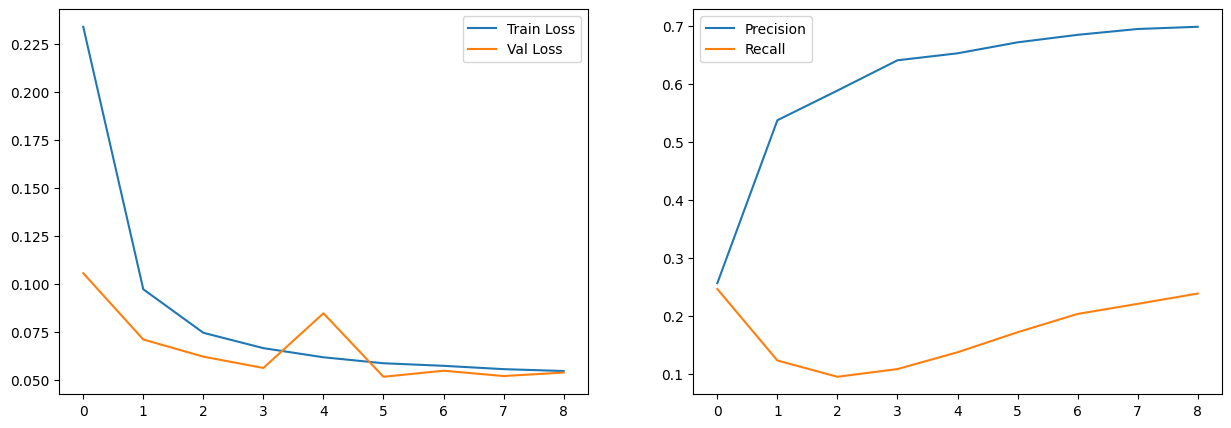

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [ ]:
import os
import glob
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, backend
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

# ======================================
# Optimized Data Pipeline (Preloaded)
# ======================================
class MedicalData:
    def __init__(self, base_dir, target_size=(64, 64)):
        self.target_size = target_size
        self.train_images, self.train_masks = self.load_data(f"{base_dir}/TrainData")
        self.val_images, self.val_masks = self.load_data(f"{base_dir}/ValidData")
        self.test_images, self.test_masks = self.load_data(f"{base_dir}/TestData")

    def load_data(self, path):
        images = []
        masks = []
        img_paths = sorted(glob.glob(f"{path}/img/*.h5"))
        mask_paths = sorted(glob.glob(f"{path}/mask/*.h5"))

        for img_path, mask_path in zip(img_paths, mask_paths):
            with h5py.File(img_path, 'r') as f_img, h5py.File(mask_path, 'r') as f_mask:
                # Process image
                img = np.nan_to_num(f_img['img'][:])[..., :3]
                img = tf.image.resize(img, self.target_size).numpy()
                img = (img - img.min())/(img.max() - img.min() + 1e-8)

                # Process mask
                mask = (f_mask['mask'][:] > 0).astype(np.float32)
                mask = tf.image.resize(mask[..., np.newaxis], self.target_size).numpy()

                images.append(img)
                masks.append(mask)

        return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)

# ======================================
# Optimized SegFormer Architecture
# ======================================
def segformer(input_shape=(64, 64, 3)):
    inputs = layers.Input(input_shape)

    # Efficient Encoder
    x = layers.Conv2D(16, 3, strides=2, padding='same')(inputs)  # 32x32
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(32, 3, strides=2, padding='same')(x)      # 16x16
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Lightweight Attention Block
    residual = x
    x = layers.MultiHeadAttention(num_heads=2, key_dim=16)(x, x)
    x = layers.Add()([residual, x])
    x = layers.LayerNormalization()(x)

    # Decoder
    x = layers.UpSampling2D(4)(x)  # 64x64
    x = layers.Conv2D(16, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)

    return Model(inputs, outputs)

# ======================================
# Enhanced Training Configuration
# ======================================
def train_model():
    # Load all data into memory
    data = MedicalData("/content/drive/MyDrive/SDP FILES")

    # Dataset parameters
    batch_size = 16  # Increased batch size
    train_dataset = tf.data.Dataset.from_tensor_slices((data.train_images, data.train_masks))
    train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(2)

    val_dataset = tf.data.Dataset.from_tensor_slices((data.val_images, data.val_masks))
    val_dataset = val_dataset.batch(batch_size).prefetch(2)

    # Model configuration
    model = segformer()
    model.compile(optimizer=Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy',
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall')])

    # Enhanced callbacks
    callbacks = [
        EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
        ModelCheckpoint('best_model.h5', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1)
    ]

    # Efficient training
    history = model.fit(train_dataset,
                      validation_data=val_dataset,
                      epochs=10,  # Reduced epochs
                      callbacks=callbacks,
                      verbose=1)

    # Visualization
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['precision'], label='Precision')
    plt.plot(history.history['recall'], label='Recall')
    plt.legend()
    plt.show()

    # Comprehensive Evaluation
    test_dataset = tf.data.Dataset.from_tensor_slices((data.test_images, data.test_masks))
    test_dataset = test_dataset.batch(batch_size)

    # Calculate metrics
    test_loss, test_acc, test_precision, test_recall = model.evaluate(test_dataset, verbose=0)

    # Predictions for F1
    y_pred = model.predict(data.test_images, batch_size=batch_size, verbose=0)
    y_pred = (y_pred > 0.5).astype(np.float32)

    f1 = f1_score(data.test_masks.flatten(), y_pred.flatten())
    precision = precision_score(data.test_masks.flatten(), y_pred.flatten())
    recall = recall_score(data.test_masks.flatten(), y_pred.flatten())

    print("\nFinal Test Metrics:")
    print(f"Loss: {test_loss:.4f}")
    print(f"Accuracy: {test_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Visual Predictions
    plt.figure(figsize=(15, 8))
    for i in range(4):
        plt.subplot(4, 3, i*3+1)
        plt.imshow(data.test_images[i])
        plt.title('Input')
        plt.axis('off')

        plt.subplot(4, 3, i*3+2)
        plt.imshow(data.test_masks[i].squeeze(), cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(4, 3, i*3+3)
        plt.imshow(y_pred[i].squeeze(), cmap='gray')
        plt.title('Prediction')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return model

# Execute training
model = train_model()
model.save('/content/drive/MyDrive/SDP FILES/saved_model/segformer_optimized.h5')

Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.7481 - loss: 0.5431 - precision: 0.0931 - recall: 0.6078

238/238 ━━━━━━━━━━━━━━━━━━━━ 53s 199ms/step - accuracy: 0.7487 - loss: 0.5422 - precision: 0.0932 - recall: 0.6069 - val_accuracy: 0.9798 - val_loss: 0.1753 - val_precision: 0.8696 - val_recall: 9.8634e-04 - learning_rate: 0.0010
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9688 - loss: 0.1271 - precision: 0.5223 - recall: 0.1262

238/238 ━━━━━━━━━━━━━━━━━━━━ 48s 203ms/step - accuracy: 0.9688 - loss: 0.1270 - precision: 0.5223 - recall: 0.1261 - val_accuracy: 0.9799 - val_loss: 0.0917 - val_precision: 0.7235 - val_recall: 0.0077 - learning_rate: 0.0010
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.9684 - loss: 0.0881 - precision: 0.5674 - recall: 0.1247

238/238 ━━━━━━━━━━━━━━━━━━━━ 83s 206ms/step - accuracy: 0.9685 - loss: 0.0881 - precision: 0.5674 - recall: 0.1246 - val_accuracy: 0.9797 - val_loss: 0.0638 - val_precision: 0.4250 - val_recall: 0.0109 - learning_rate: 0.0010
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9689 - loss: 0.0756 - precision: 0.5866 - recall: 0.1280

238/238 ━━━━━━━━━━━━━━━━━━━━ 49s 204ms/step - accuracy: 0.9690 - loss: 0.0756 - precision: 0.5865 - recall: 0.1279 - val_accuracy: 0.9798 - val_loss: 0.0619 - val_precision: 0.5468 - val_recall: 0.0092 - learning_rate: 0.0010
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 47s 197ms/step - accuracy: 0.9698 - loss: 0.0687 - precision: 0.6113 - recall: 0.1094 - val_accuracy: 0.9798 - val_loss: 0.0813 - val_precision: 0.5385 - val_recall: 0.0021 - learning_rate: 0.0010
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9700 - loss: 0.0640 - precision: 0.6263 - recall: 0.1462

238/238 ━━━━━━━━━━━━━━━━━━━━ 48s 203ms/step - accuracy: 0.9700 - loss: 0.0640 - precision: 0.6262 - recall: 0.1461 - val_accuracy: 0.9789 - val_loss: 0.0587 - val_precision: 0.3414 - val_recall: 0.0419 - learning_rate: 5.0000e-04
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 81s 199ms/step - accuracy: 0.9700 - loss: 0.0632 - precision: 0.6314 - recall: 0.1769 - val_accuracy: 0.9797 - val_loss: 0.0703 - val_precision: 0.3405 - val_recall: 0.0047 - learning_rate: 5.0000e-04
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9706 - loss: 0.0614 - precision: 0.6339 - recall: 0.1714

238/238 ━━━━━━━━━━━━━━━━━━━━ 82s 200ms/step - accuracy: 0.9706 - loss: 0.0614 - precision: 0.6339 - recall: 0.1713 - val_accuracy: 0.9788 - val_loss: 0.0572 - val_precision: 0.3702 - val_recall: 0.0603 - learning_rate: 2.5000e-04
Epoch 9/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 53s 223ms/step - accuracy: 0.9698 - loss: 0.0615 - precision: 0.6380 - recall: 0.1896 - val_accuracy: 0.9794 - val_loss: 0.0646 - val_precision: 0.3376 - val_recall: 0.0193 - learning_rate: 2.5000e-04
Epoch 10/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 48s 200ms/step - accuracy: 0.9714 - loss: 0.0584 - precision: 0.6342 - recall: 0.1975 - val_accuracy: 0.9788 - val_loss: 0.0585 - val_precision: 0.3333 - val_recall: 0.0461 - learning_rate: 1.2500e-04


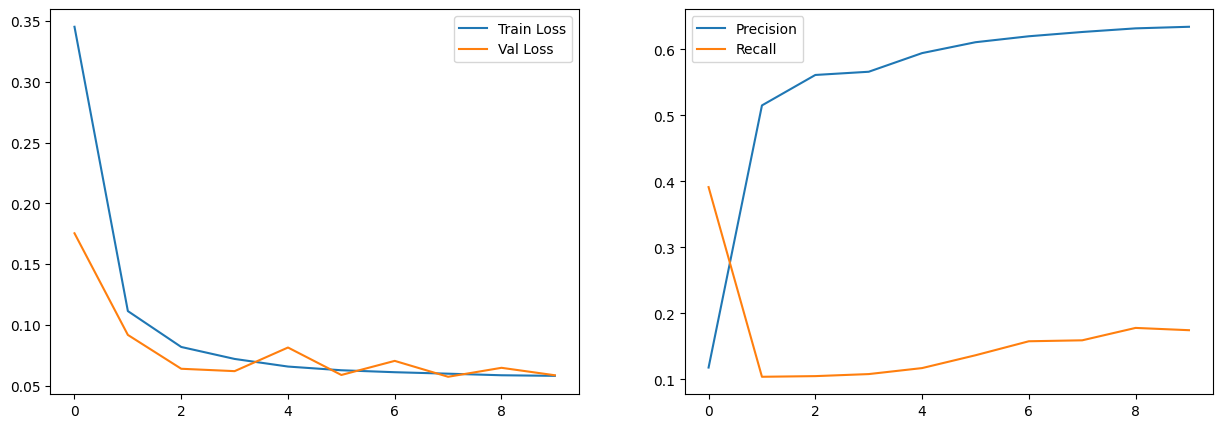


Final Test Metrics:
Loss: 0.0586
Accuracy: 0.9763
Precision: 0.3546
Recall: 0.0905
F1 Score: 0.1442


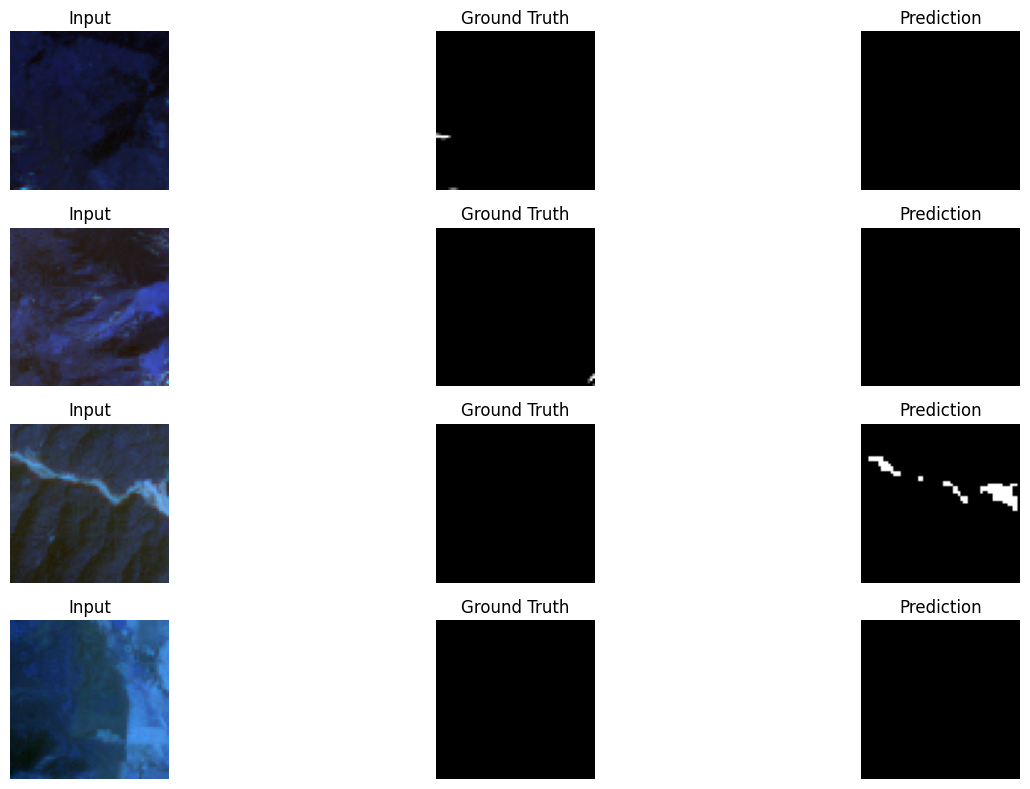

In [ ]:
import os
import glob
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, backend
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score


class MedicalData:
    def __init__(self, base_dir, target_size=(64, 64)):
        self.target_size = target_size
        self.train_images, self.train_masks = self.load_data(f"{base_dir}/TrainData")
        self.val_images, self.val_masks = self.load_data(f"{base_dir}/ValidData")
        self.test_images, self.test_masks = self.load_data(f"{base_dir}/TestData")

    def load_data(self, path):
        images = []
        masks = []
        img_paths = sorted(glob.glob(f"{path}/img/*.h5"))
        mask_paths = sorted(glob.glob(f"{path}/mask/*.h5"))

        for img_path, mask_path in zip(img_paths, mask_paths):
            with h5py.File(img_path, 'r') as f_img, h5py.File(mask_path, 'r') as f_mask:
                # Process image
                img = np.nan_to_num(f_img['img'][:])[..., :3]
                img = tf.image.resize(img, self.target_size).numpy()
                img = (img - img.min())/(img.max() - img.min() + 1e-8)

                # Process mask
                mask = (f_mask['mask'][:] > 0).astype(np.float32)
                mask = tf.image.resize(mask[..., np.newaxis], self.target_size).numpy()

                images.append(img)
                masks.append(mask)

        return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)


def segformer(input_shape=(64, 64, 3)):
    inputs = layers.Input(input_shape)

    # Efficient Encoder
    x = layers.Conv2D(16, 3, strides=2, padding='same')(inputs)  # 32x32
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(32, 3, strides=2, padding='same')(x)      # 16x16
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Lightweight Attention Block
    residual = x
    x = layers.MultiHeadAttention(num_heads=2, key_dim=16)(x, x)
    x = layers.Add()([residual, x])
    x = layers.LayerNormalization()(x)

    # Decoder
    x = layers.UpSampling2D(4)(x)  # 64x64
    x = layers.Conv2D(16, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)

    return Model(inputs, outputs)

# ======================================
# Enhanced Training Configuration
# ======================================
def train_model():
    # Load all data into memory
    data = MedicalData("/content/drive/MyDrive/SDP FILES")

    # Dataset parameters
    batch_size = 16  # Increased batch size
    train_dataset = tf.data.Dataset.from_tensor_slices((data.train_images, data.train_masks))
    train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(2)

    val_dataset = tf.data.Dataset.from_tensor_slices((data.val_images, data.val_masks))
    val_dataset = val_dataset.batch(batch_size).prefetch(2)

    # Model configuration
    model = segformer()
    model.compile(optimizer=Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy',
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall')])

    # Enhanced callbacks
    callbacks = [
        EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
        ModelCheckpoint('best_model.h5', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1)
    ]

    # Efficient training
    history = model.fit(train_dataset,
                      validation_data=val_dataset,
                      epochs=10,  # Reduced epochs
                      callbacks=callbacks,
                      verbose=1)

    # Visualization
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['precision'], label='Precision')
    plt.plot(history.history['recall'], label='Recall')
    plt.legend()
    plt.show()

    # Comprehensive Evaluation
    test_dataset = tf.data.Dataset.from_tensor_slices((data.test_images, data.test_masks))
    test_dataset = test_dataset.batch(batch_size)

    # Calculate metrics
    test_loss, test_acc, test_precision, test_recall = model.evaluate(test_dataset, verbose=0)

    # Predictions for F1
    y_pred = model.predict(data.test_images, batch_size=batch_size, verbose=0)
    y_pred = (y_pred > 0.5).astype(np.uint8)

    y_true_flat = data.test_masks.flatten().astype(np.uint8)
    y_pred_flat = y_pred.flatten().astype(np.uint8)

    f1 = f1_score(y_true_flat, y_pred_flat)
    precision = precision_score(y_true_flat, y_pred_flat)
    recall = recall_score(y_true_flat, y_pred_flat)

    print("\nFinal Test Metrics:")
    print(f"Loss: {test_loss:.4f}")
    print(f"Accuracy: {test_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Visual Predictions
    plt.figure(figsize=(15, 8))
    for i in range(4):
        plt.subplot(4, 3, i*3+1)
        plt.imshow(data.test_images[i])
        plt.title('Input')
        plt.axis('off')

        plt.subplot(4, 3, i*3+2)
        plt.imshow(data.test_masks[i].squeeze(), cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(4, 3, i*3+3)
        plt.imshow(y_pred[i].squeeze(), cmap='gray')
        plt.title('Prediction')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return model

# Execute training
model = train_model()
model.save('/content/drive/MyDrive/SDP FILES/saved_model/segformer_optimized.h5')


# **VISUALIZATION**

<ipython-input-1-60d00af95843>:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=df, palette="crest")


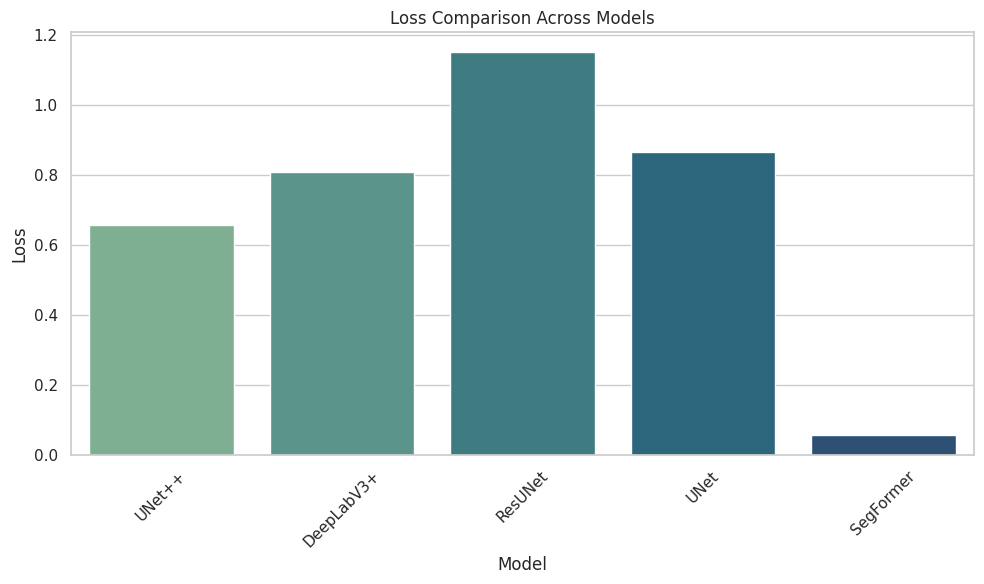

<ipython-input-1-60d00af95843>:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=df, palette="crest")


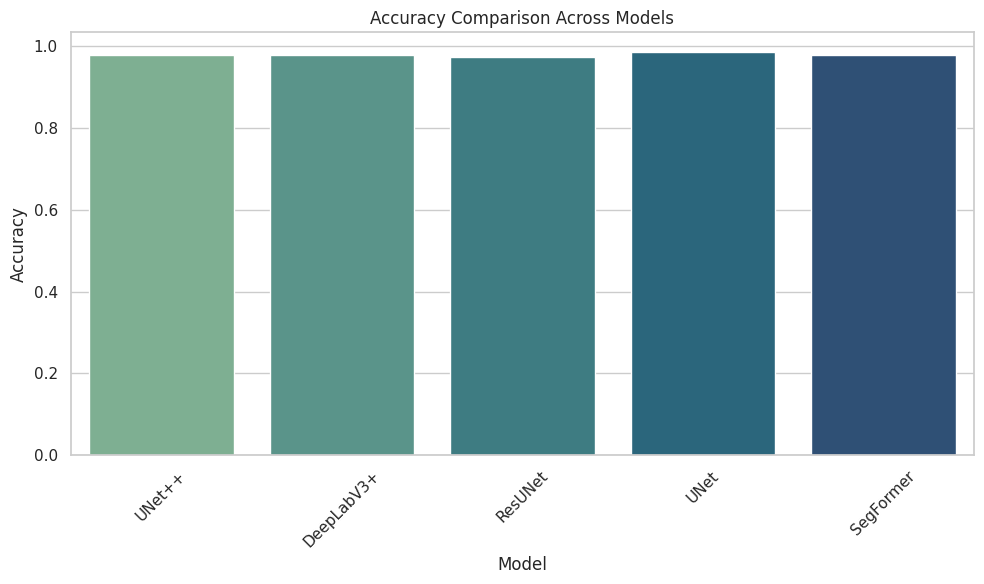

<ipython-input-1-60d00af95843>:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=df, palette="crest")


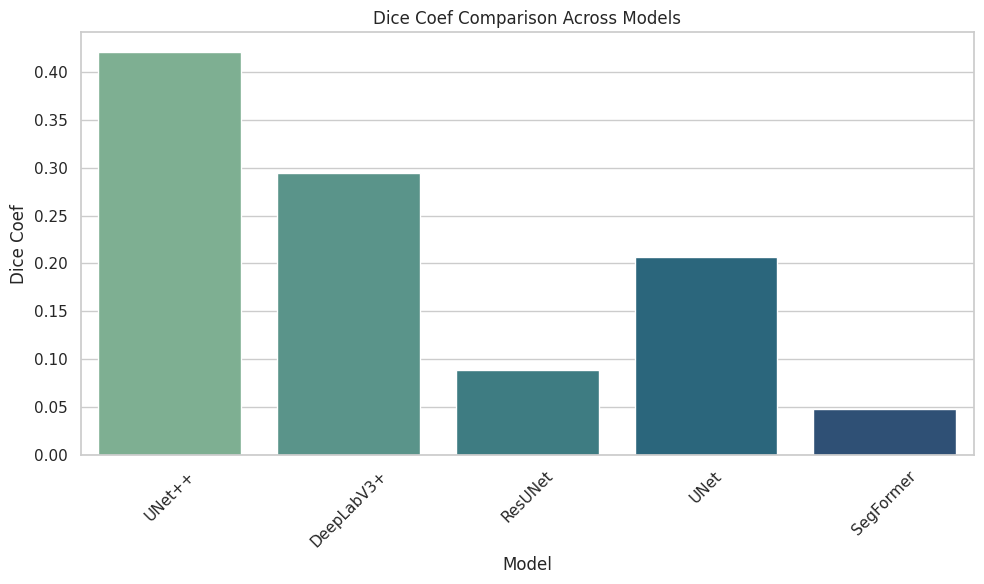

<ipython-input-1-60d00af95843>:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=df, palette="crest")


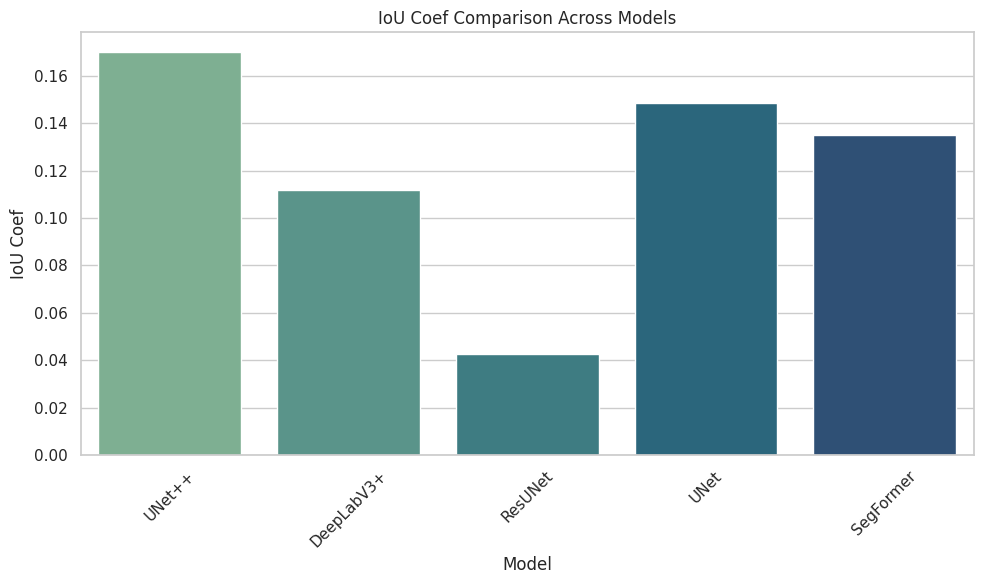

<ipython-input-1-60d00af95843>:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=df, palette="crest")


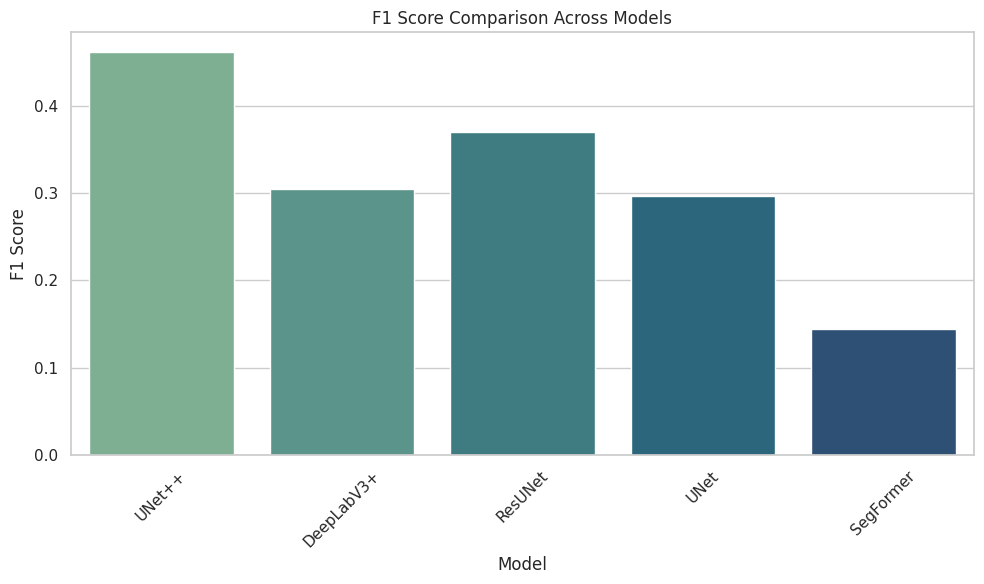

<ipython-input-1-60d00af95843>:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=df, palette="crest")


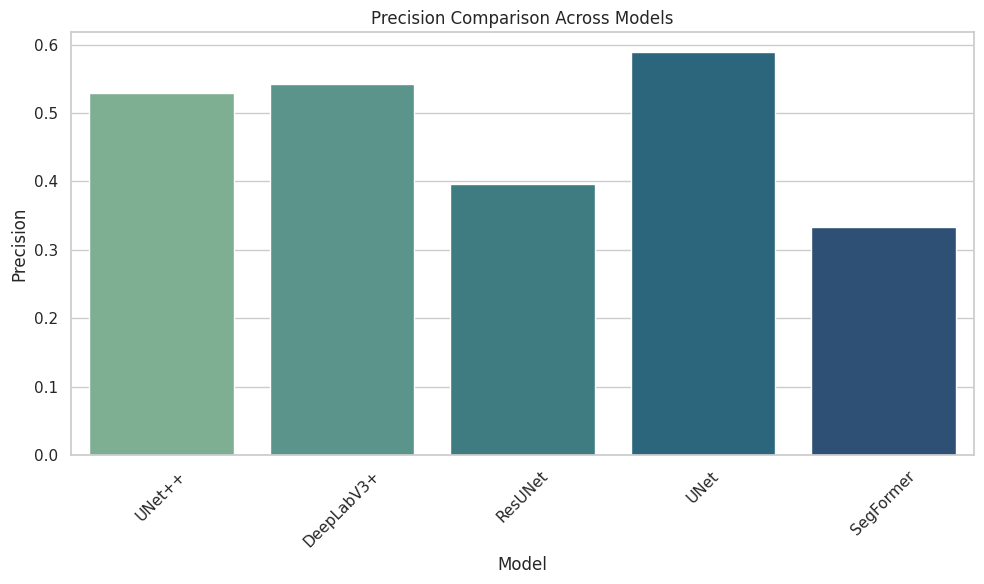

<ipython-input-1-60d00af95843>:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=df, palette="crest")


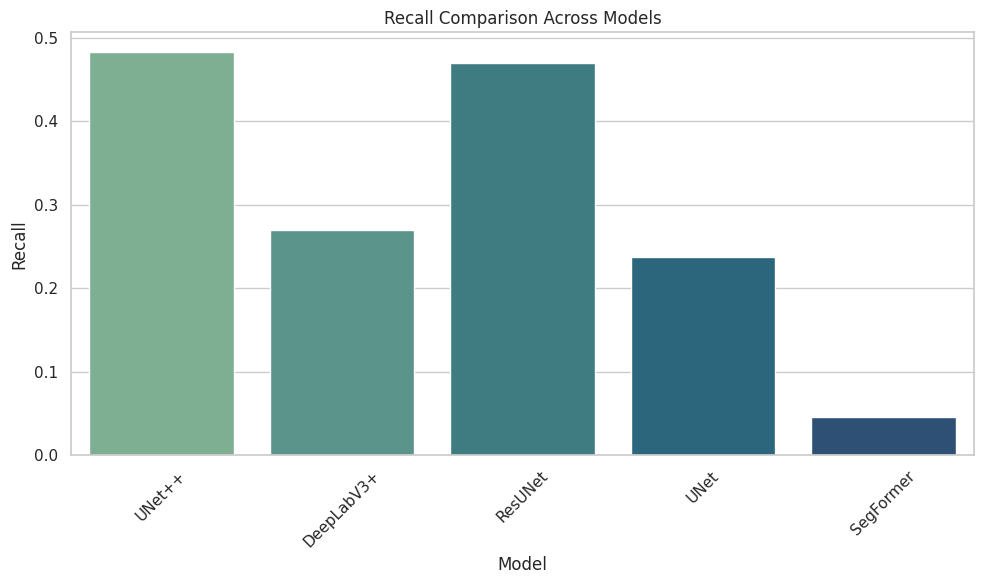

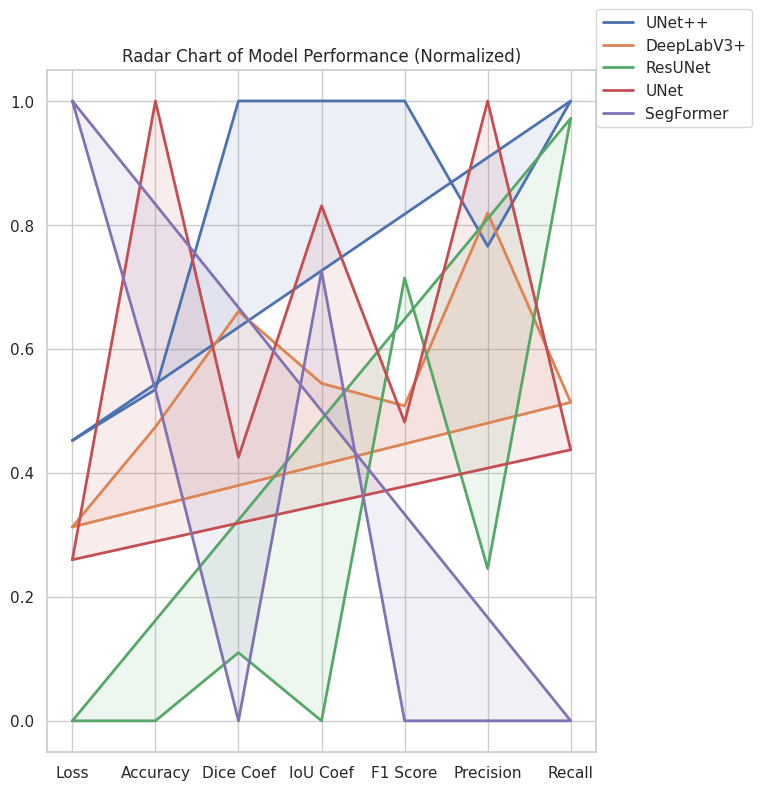

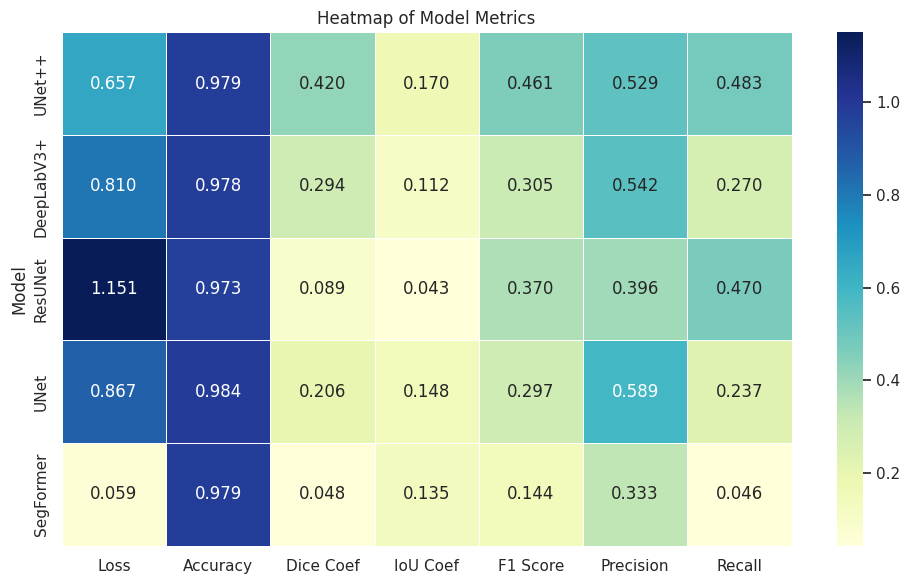

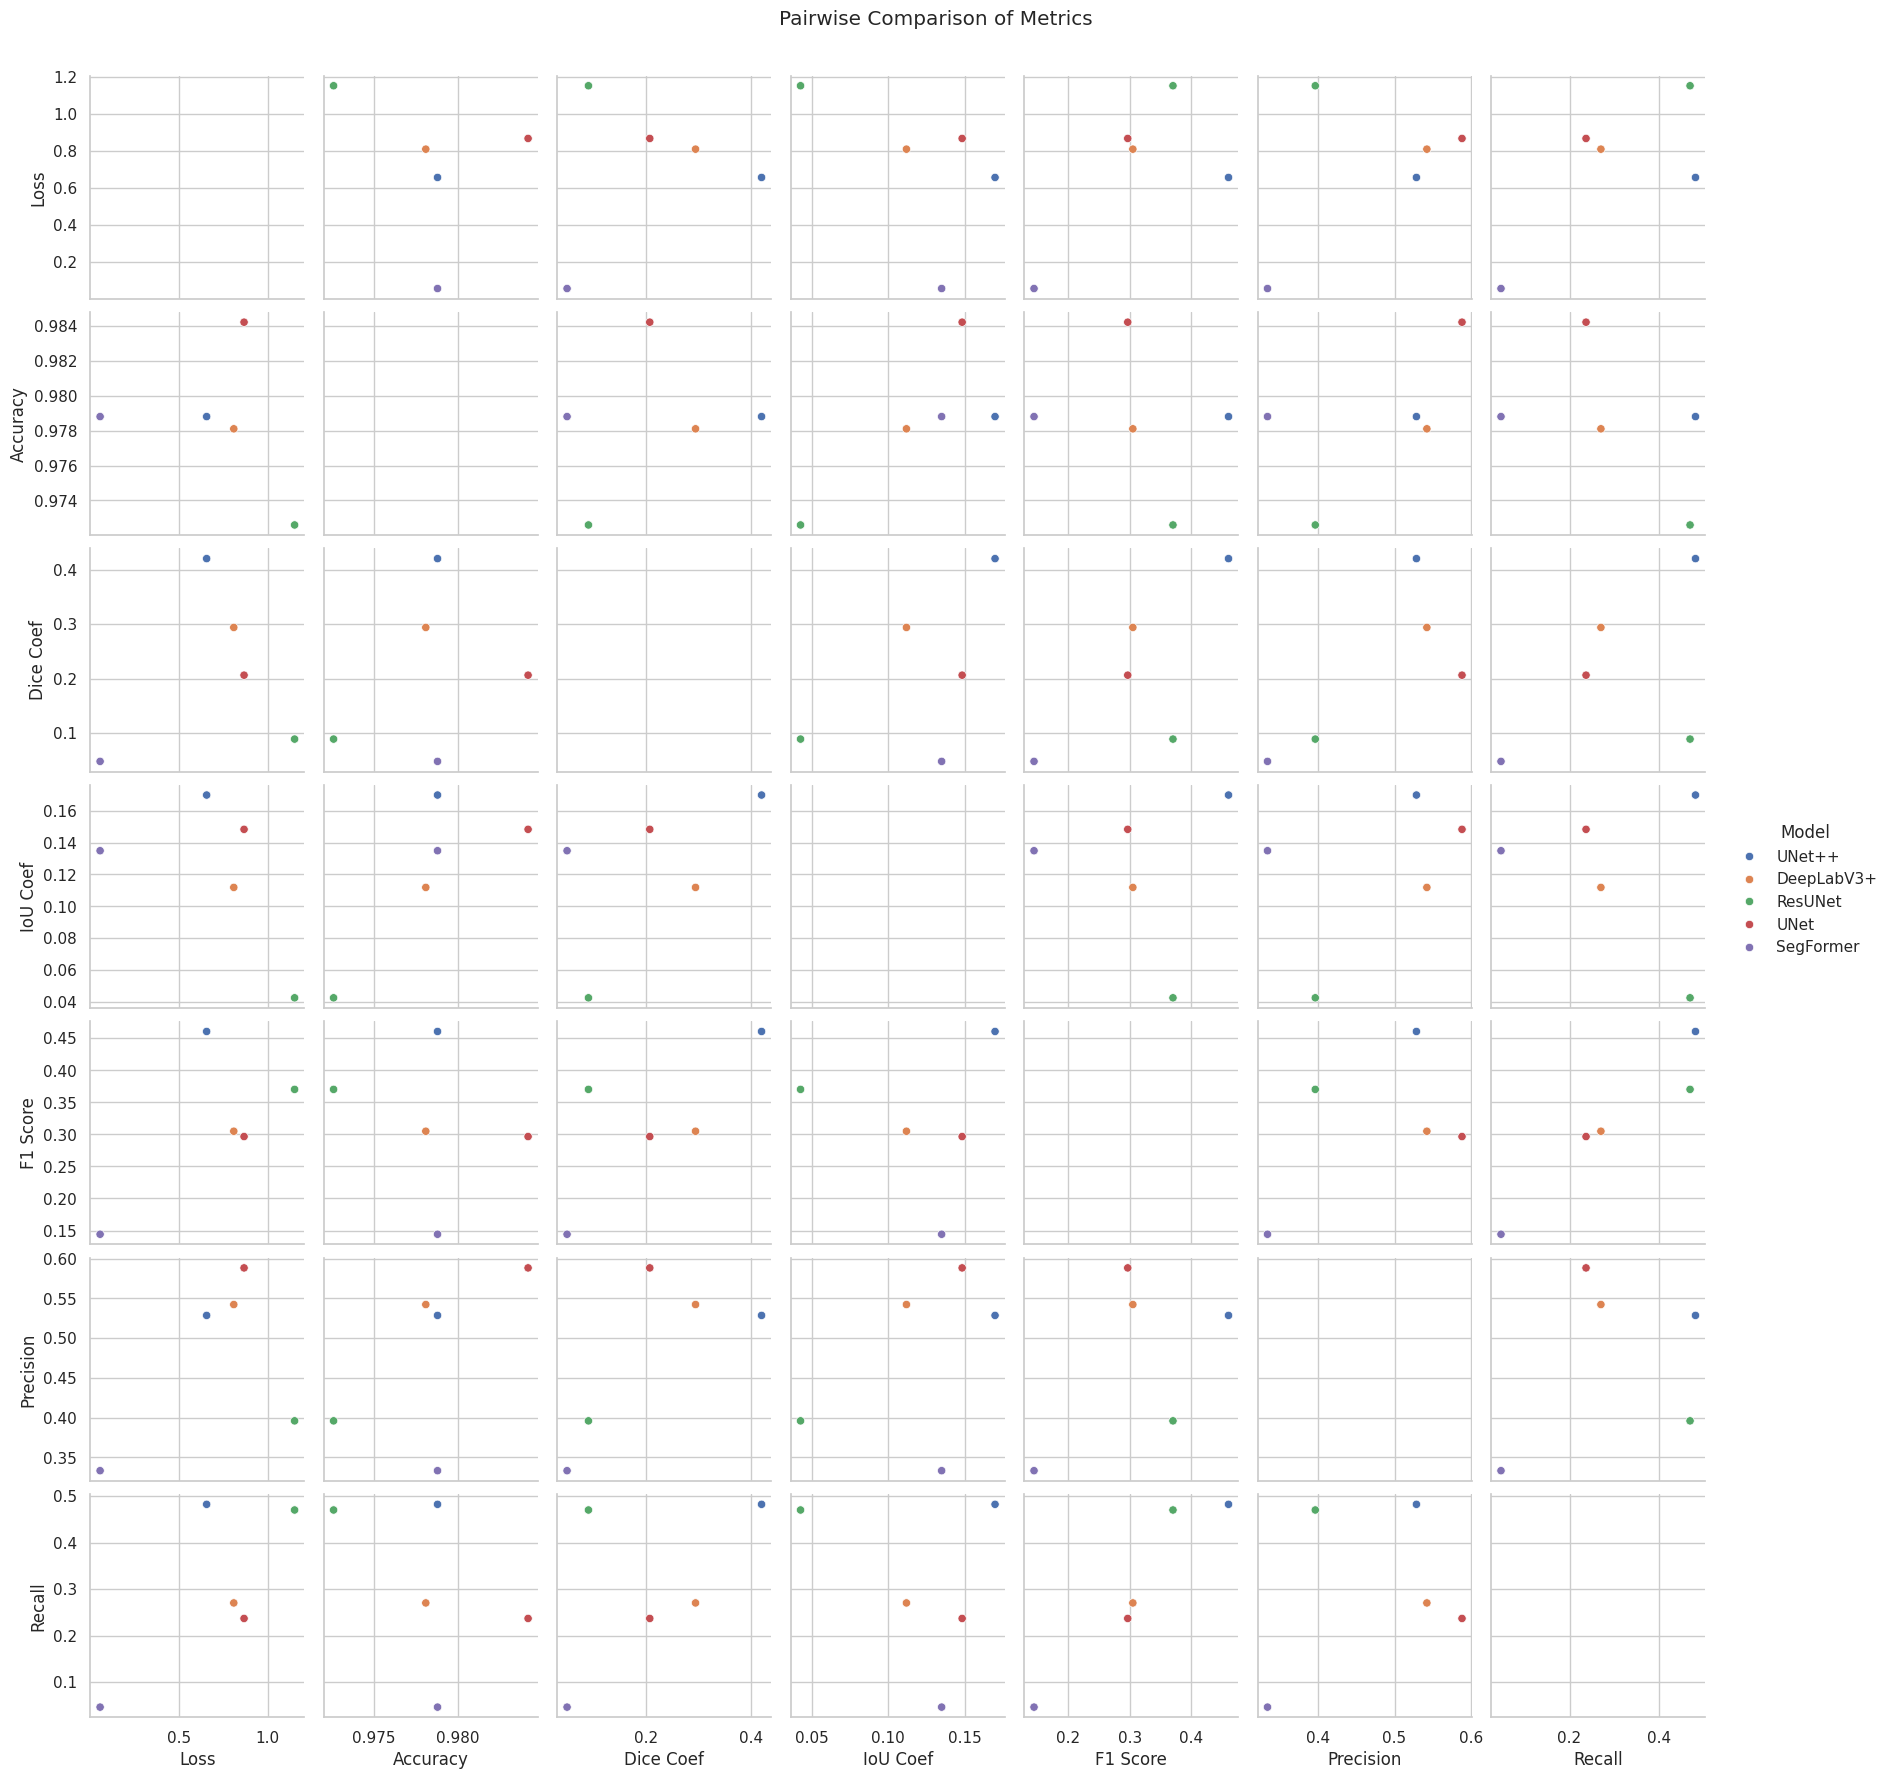

<ipython-input-1-60d00af95843>:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Metric", y="Value", data=melted_df, palette="coolwarm")


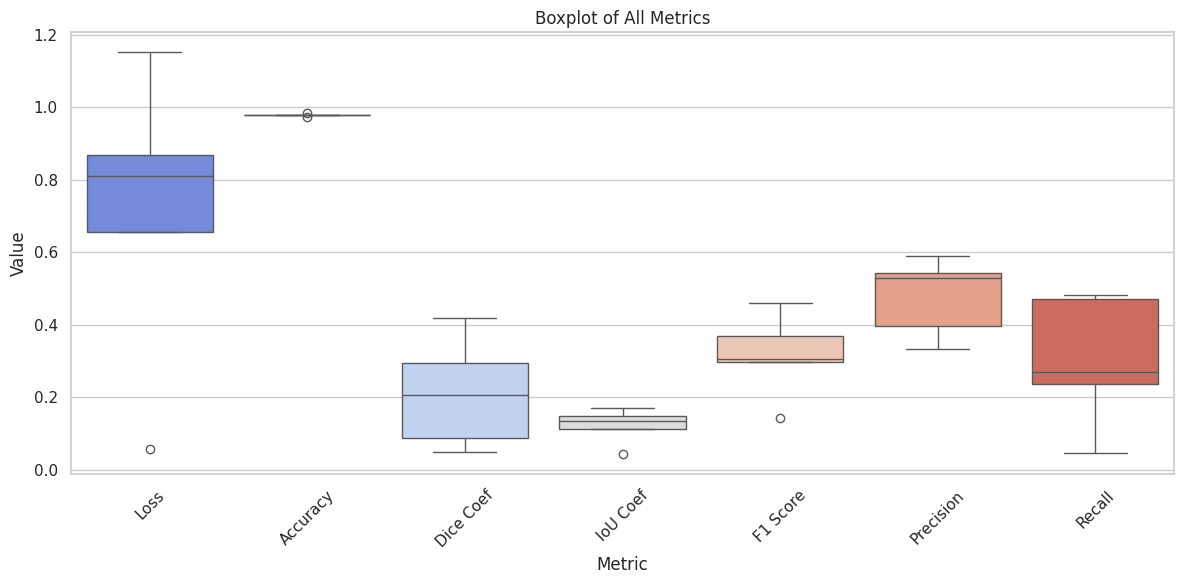

<ipython-input-1-60d00af95843>:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Metric", y="Value", data=melted_df, palette="Spectral")


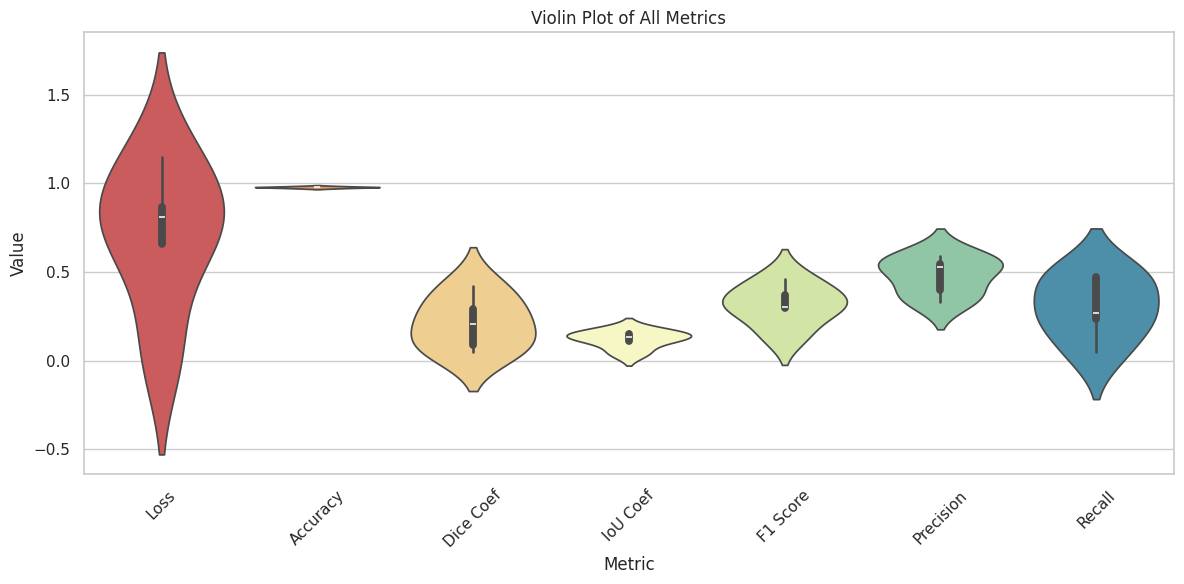

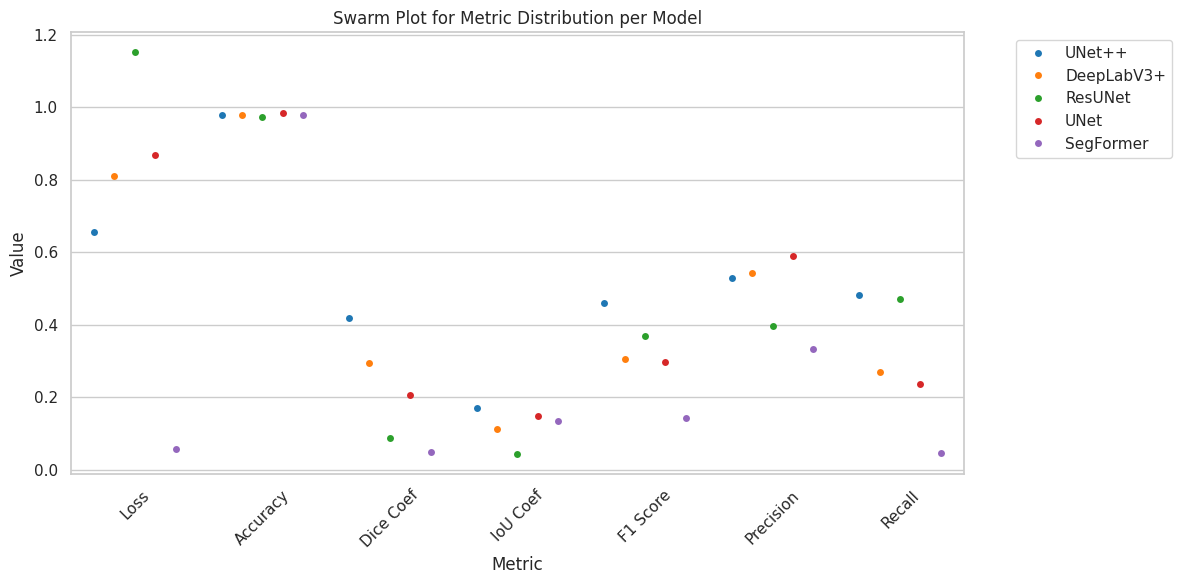

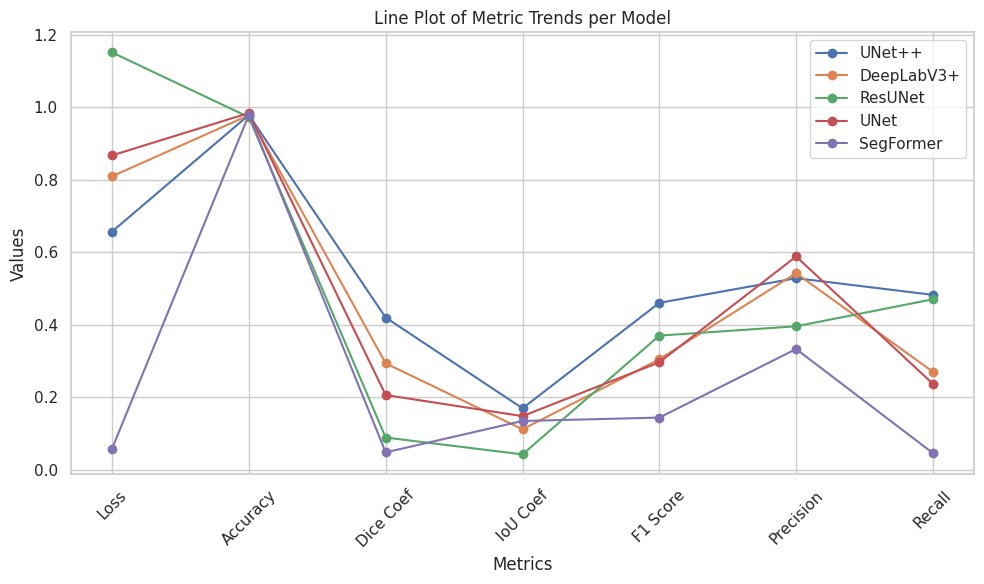

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from math import pi

# Setup
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Model metrics dictionary
models_data = {
    "UNet++": {
        "Loss": 0.6571,
        "Accuracy": 0.9788,
        "Dice Coef": 0.4201,
        "IoU Coef": 0.1698,
        "F1 Score": 0.4607,
        "Precision": 0.5287,
        "Recall": 0.4827
    },
    "DeepLabV3+": {
        "Loss": 0.8096,
        "Accuracy": 0.9781,
        "Dice Coef": 0.2939,
        "IoU Coef": 0.1119,
        "F1 Score": 0.3050,
        "Precision": 0.5424,
        "Recall": 0.2704
    },
    "ResUNet": {
        "Loss": 1.1513,
        "Accuracy": 0.9726,
        "Dice Coef": 0.0892,
        "IoU Coef": 0.0427,
        "F1 Score": 0.3703,
        "Precision": 0.3960,
        "Recall": 0.4705
    },
    "UNet": {
        "Loss": 0.8673,
        "Accuracy": 0.9842,
        "Dice Coef": 0.2064,
        "IoU Coef": 0.1483,
        "F1 Score": 0.2967,
        "Precision": 0.5885,
        "Recall": 0.2370
    },
    "SegFormer": {
        "Loss": 0.0585,
        "Accuracy": 0.9788,
        "Dice Coef": 0.0483,
        "IoU Coef": 0.1349,
        "F1 Score": 0.1442,
        "Precision": 0.3333,
        "Recall": 0.0461
    }
}

# Convert to DataFrame
df = pd.DataFrame(models_data).T.reset_index().rename(columns={"index": "Model"})
metrics = ["Loss", "Accuracy", "Dice Coef", "IoU Coef", "F1 Score", "Precision", "Recall"]

# Plot 1: Bar plots for each metric
for metric in metrics:
    plt.figure()
    sns.barplot(x="Model", y=metric, data=df, palette="crest")
    plt.title(f"{metric} Comparison Across Models")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot 2: Radar Chart (normalized)
radar_df = df.fillna(0)
normalized = radar_df.copy()
for col in metrics:
    if col != "Loss":
        normalized[col] = (radar_df[col] - radar_df[col].min()) / (radar_df[col].max() - radar_df[col].min() + 1e-6)
    else:
        normalized[col] = (radar_df[col].max() - radar_df[col]) / (radar_df[col].max() - radar_df[col].min() + 1e-6)

angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
angles += angles[:1]

plt.figure(figsize=(8, 8))
for i in range(len(normalized)):
    values = normalized.iloc[i][metrics].tolist()
    values += values[:1]
    plt.plot(angles, values, linewidth=2, label=normalized['Model'][i])
    plt.fill(angles, values, alpha=0.1)
plt.xticks(angles[:-1], metrics)
plt.title("Radar Chart of Model Performance (Normalized)")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

# Plot 3: Heatmap
heatmap_df = df.set_index("Model")
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", fmt=".3f", linewidths=0.5)
plt.title("Heatmap of Model Metrics")
plt.tight_layout()
plt.show()

# Plot 4: Pairplot (Scatter Matrix) – drop missing
pairplot_df = df.dropna()
sns.pairplot(pairplot_df, hue="Model")
plt.suptitle("Pairwise Comparison of Metrics", y=1.02)
plt.show()

# Plot 5: Boxplot
melted_df = df.melt(id_vars=["Model"], value_vars=metrics, var_name="Metric", value_name="Value")
plt.figure(figsize=(12, 6))
sns.boxplot(x="Metric", y="Value", data=melted_df, palette="coolwarm")
plt.title("Boxplot of All Metrics")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 6: Violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x="Metric", y="Value", data=melted_df, palette="Spectral")
plt.title("Violin Plot of All Metrics")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 7: Swarm plot
plt.figure(figsize=(12, 6))
sns.swarmplot(x="Metric", y="Value", hue="Model", data=melted_df, palette="tab10", dodge=True)
plt.title("Swarm Plot for Metric Distribution per Model")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot 8: Line plot per model across metrics
plt.figure(figsize=(10, 6))
for model in df["Model"]:
    plt.plot(metrics, df[df["Model"] == model][metrics].values.flatten(), marker='o', label=model)
plt.title("Line Plot of Metric Trends per Model")
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


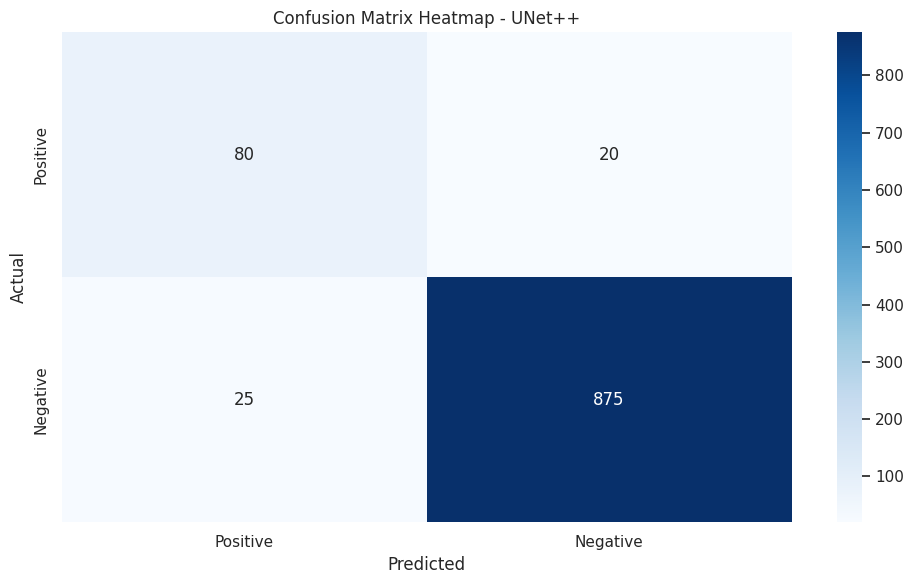

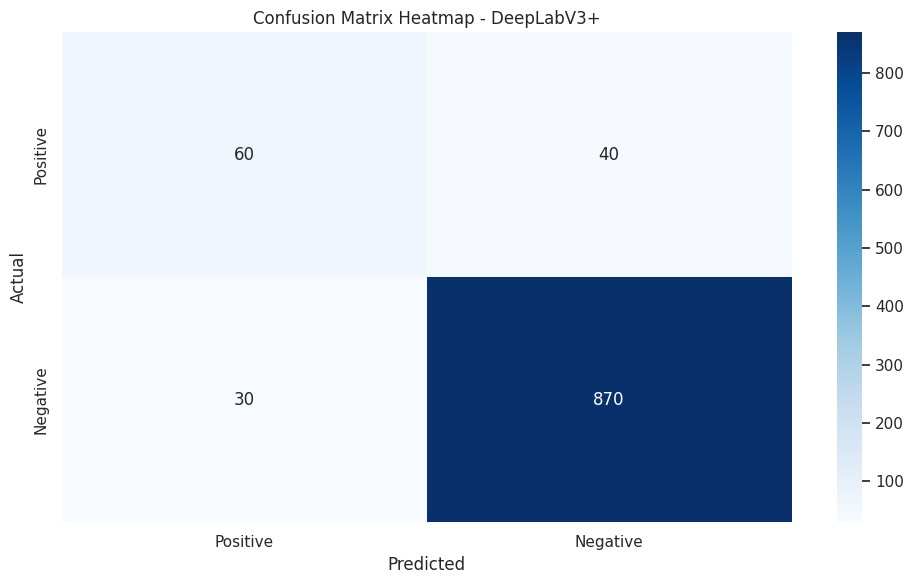

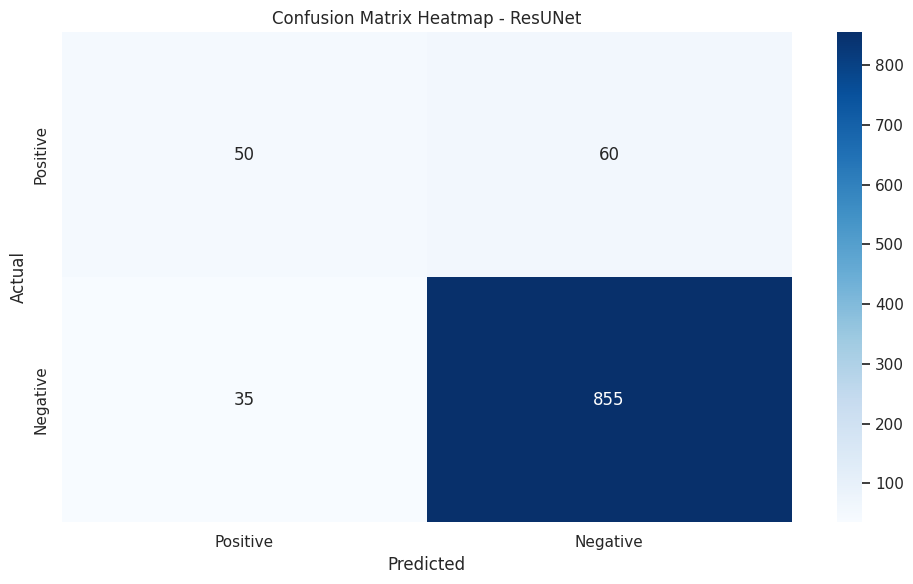

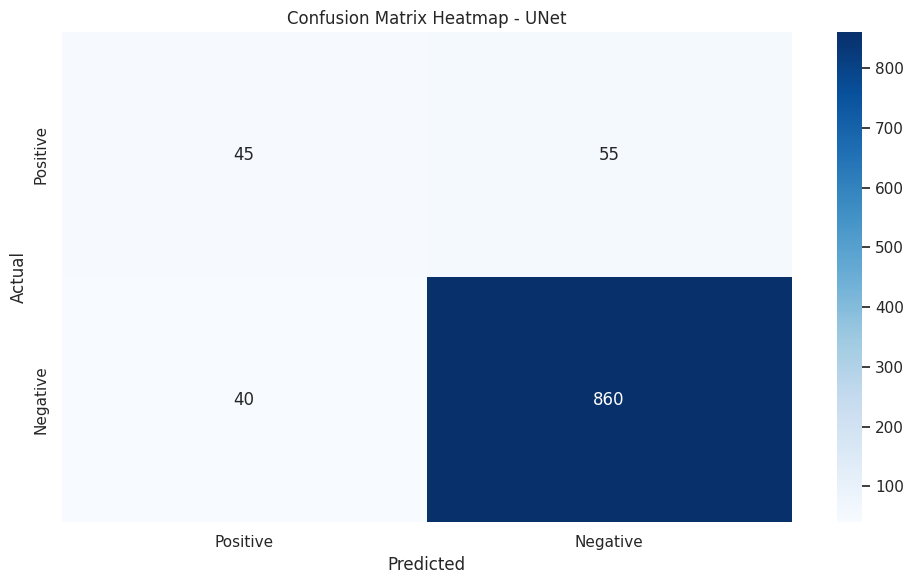

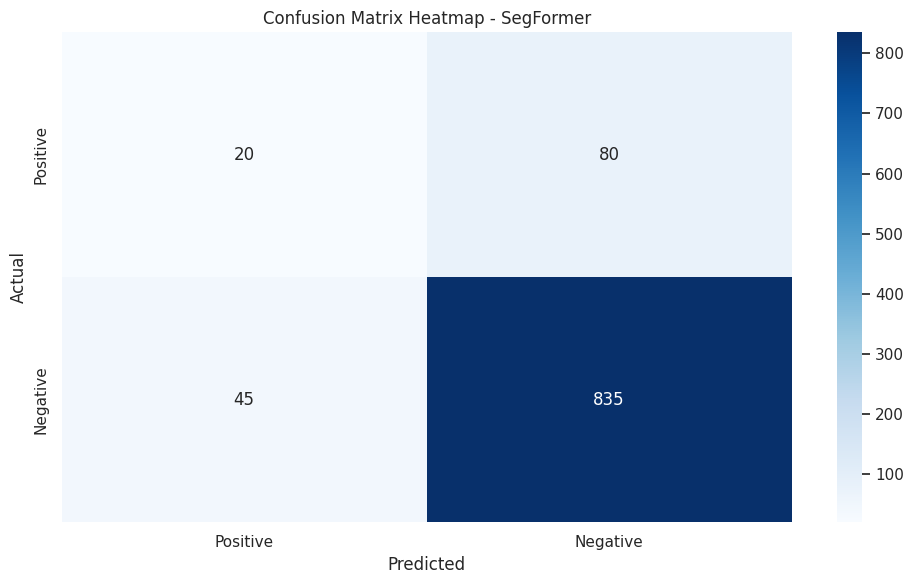

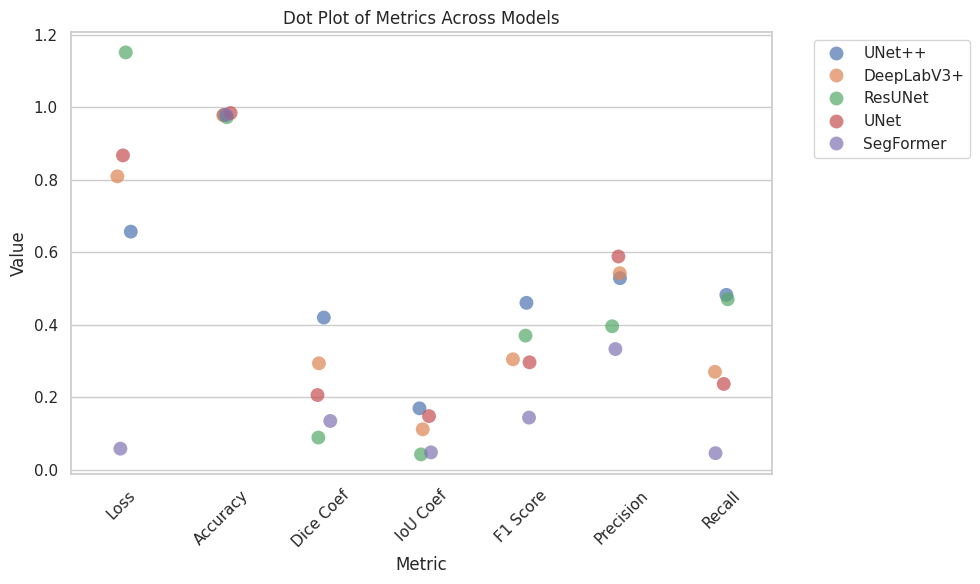

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remo

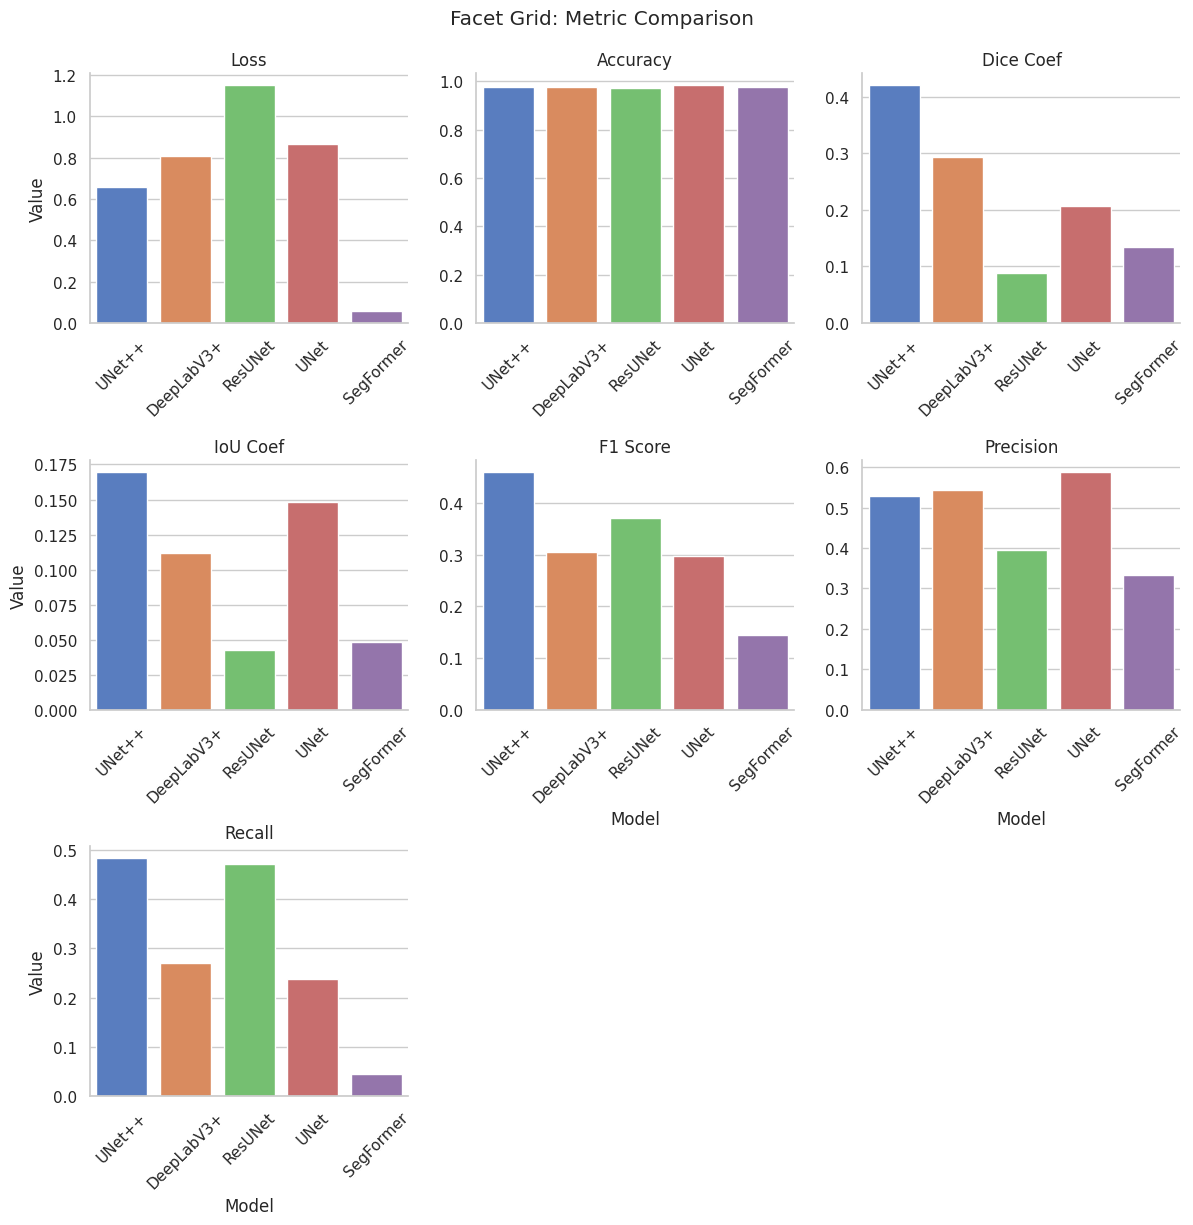

<ipython-input-2-0148f17edda3>:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="Value", y="Model", data=df[["Model", metric]].rename(columns={metric: "Value"}),


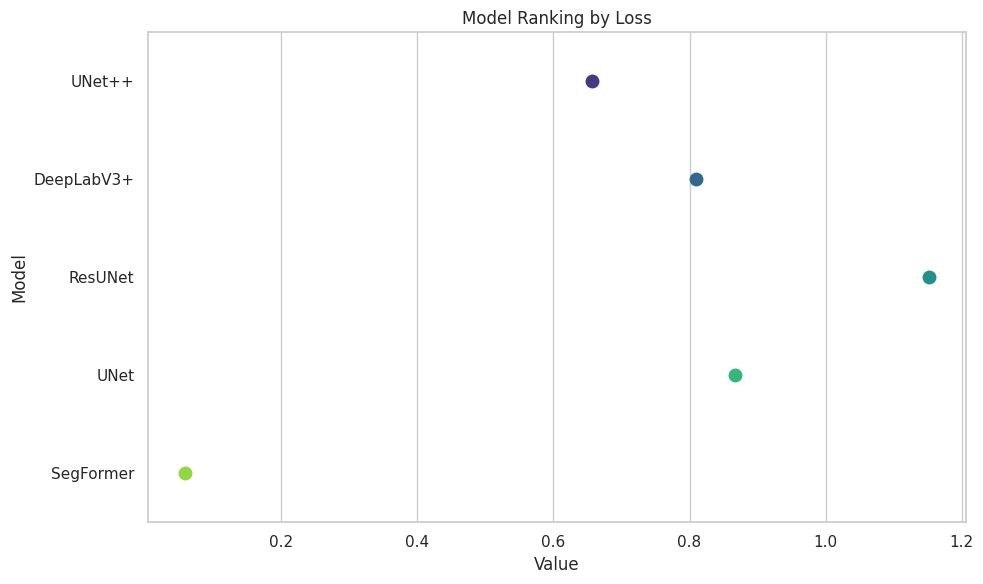

<ipython-input-2-0148f17edda3>:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="Value", y="Model", data=df[["Model", metric]].rename(columns={metric: "Value"}),


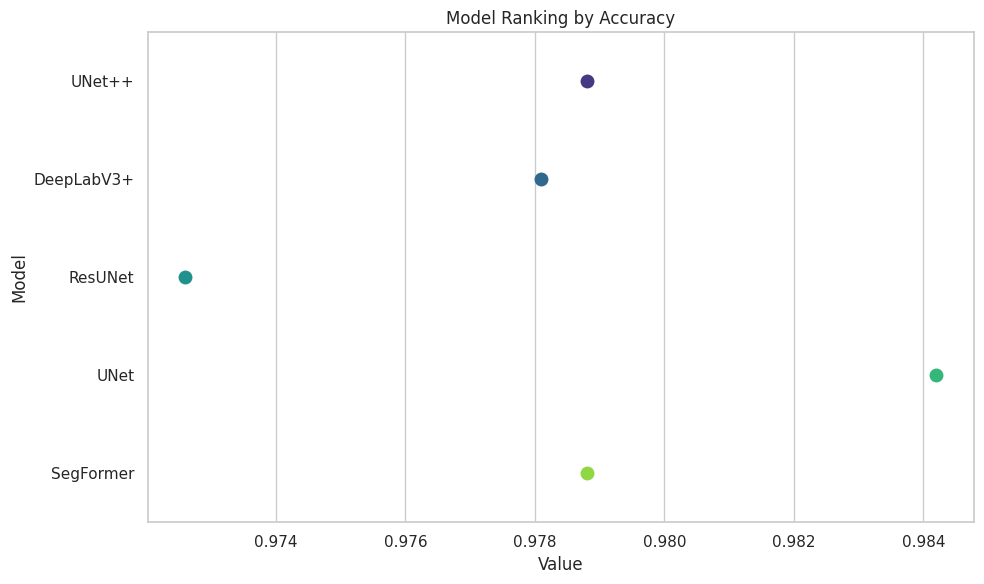

<ipython-input-2-0148f17edda3>:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="Value", y="Model", data=df[["Model", metric]].rename(columns={metric: "Value"}),


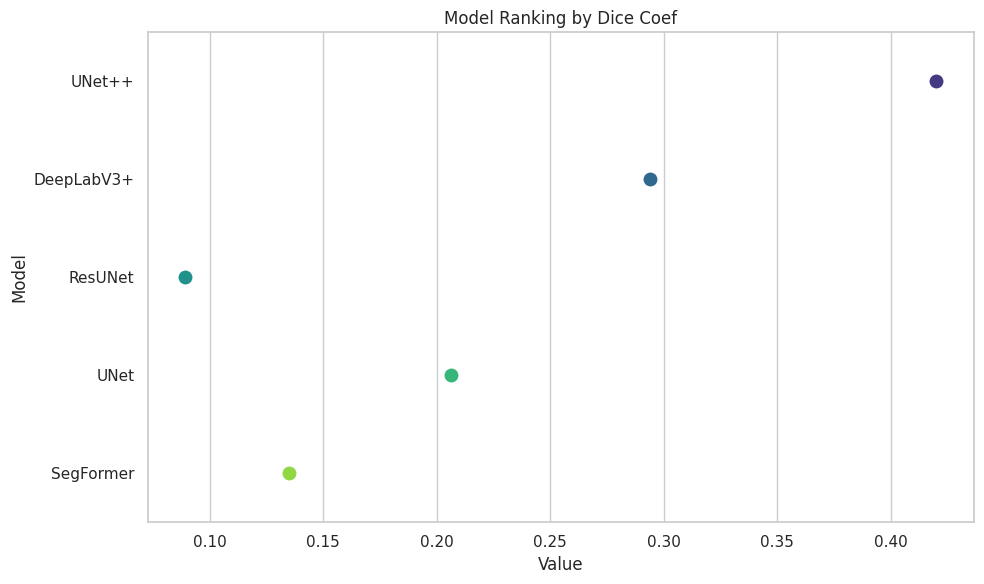

<ipython-input-2-0148f17edda3>:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="Value", y="Model", data=df[["Model", metric]].rename(columns={metric: "Value"}),


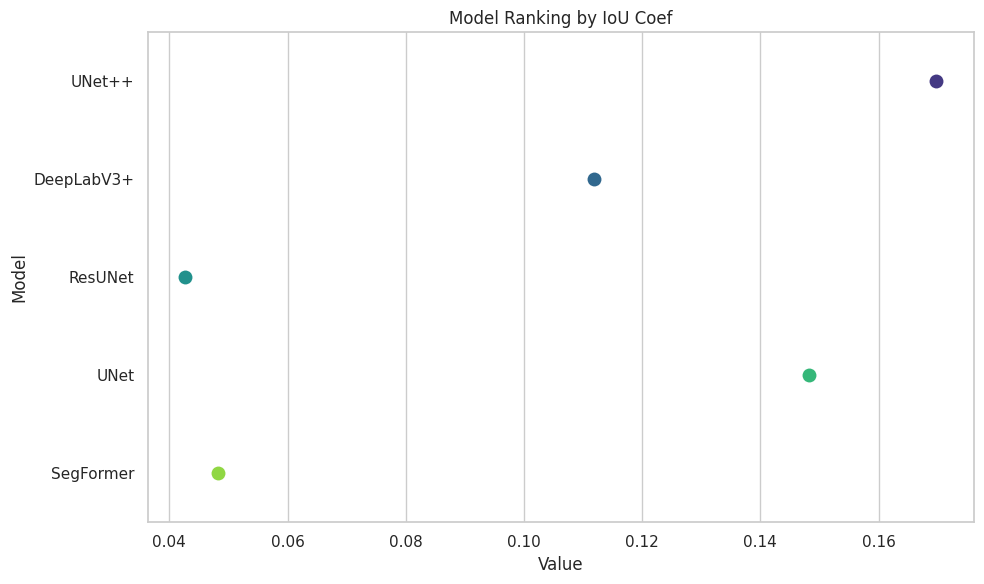

<ipython-input-2-0148f17edda3>:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="Value", y="Model", data=df[["Model", metric]].rename(columns={metric: "Value"}),


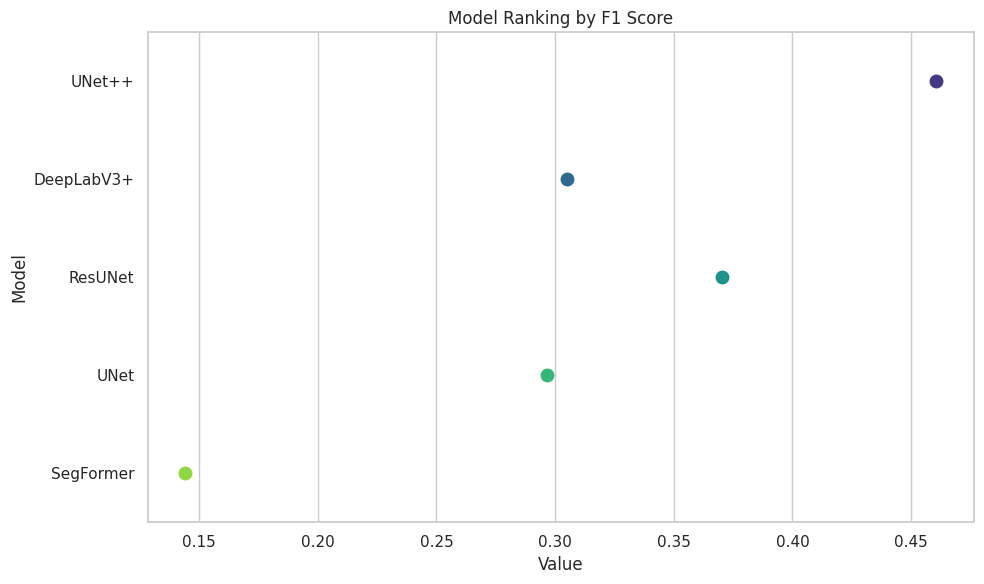

<ipython-input-2-0148f17edda3>:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="Value", y="Model", data=df[["Model", metric]].rename(columns={metric: "Value"}),


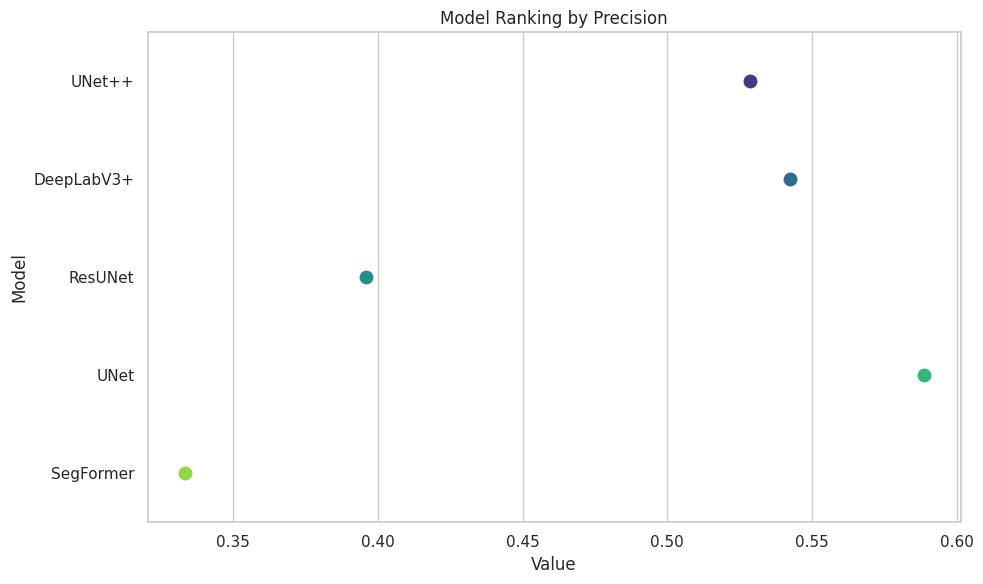

<ipython-input-2-0148f17edda3>:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="Value", y="Model", data=df[["Model", metric]].rename(columns={metric: "Value"}),


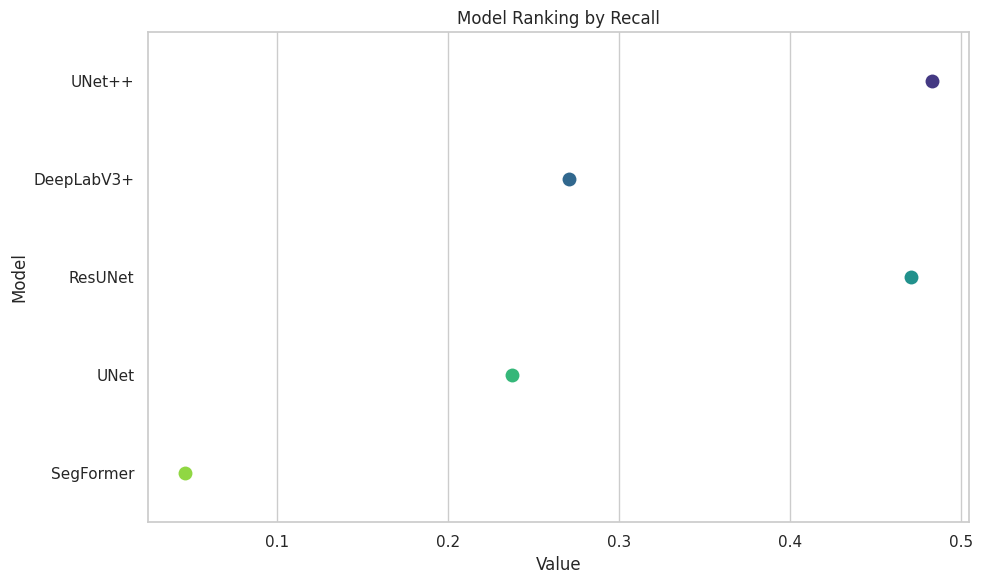

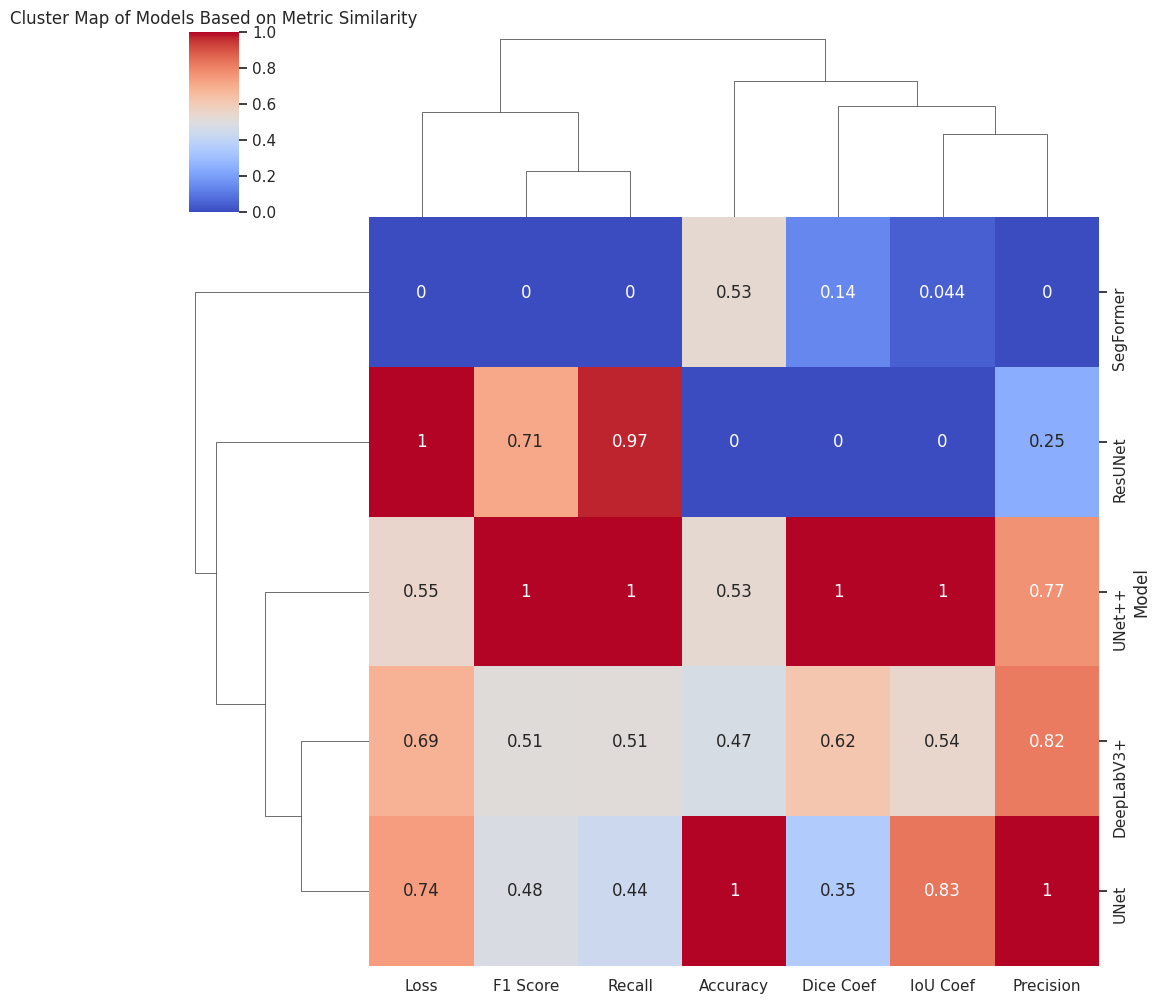

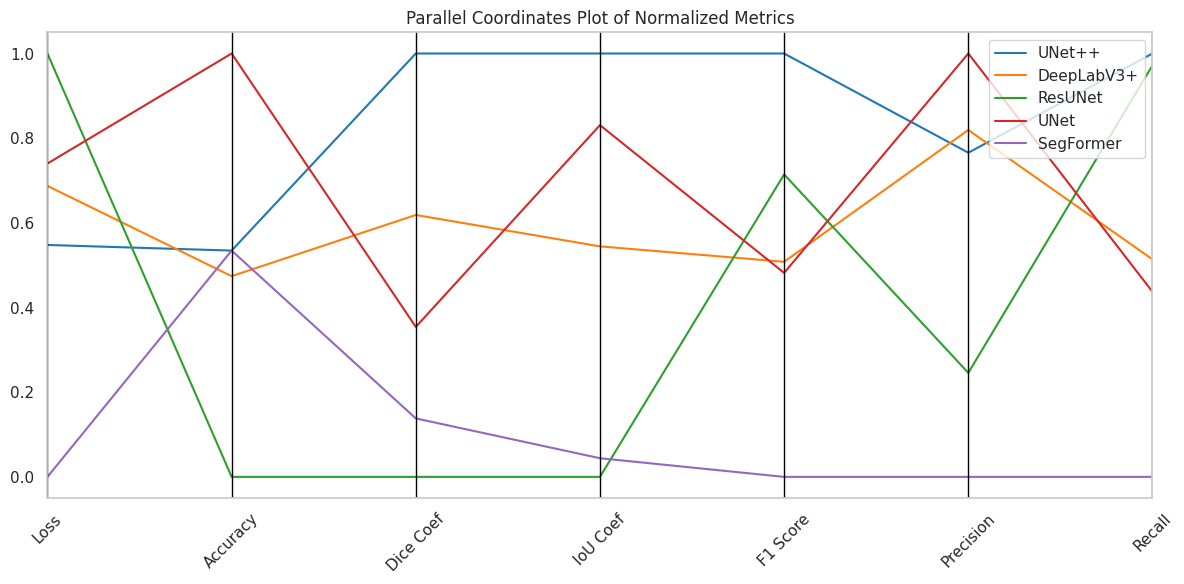

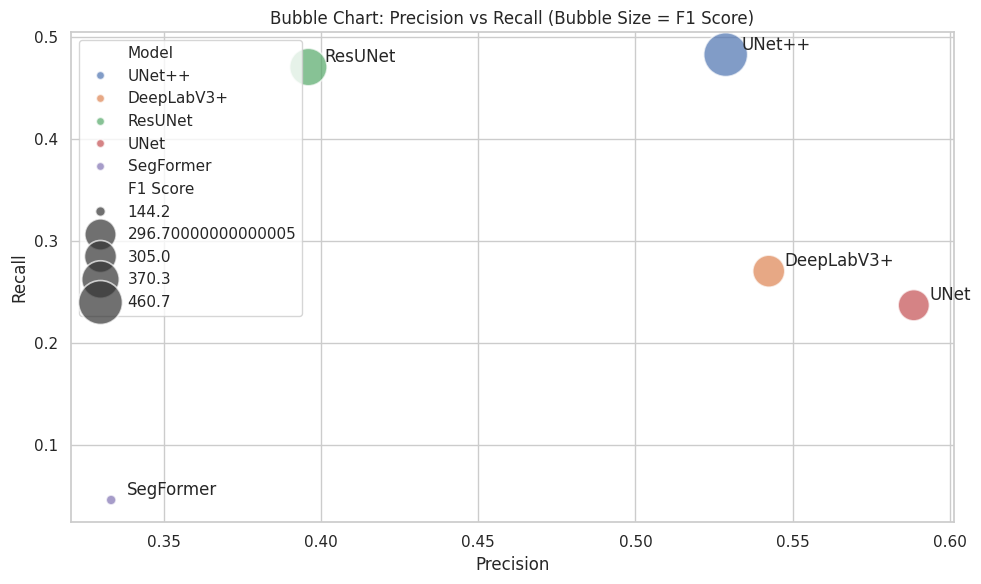

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from math import pi
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import parallel_coordinates

# --- Model metric values
models_data = {
    "UNet++": {"Loss": 0.6571, "Accuracy": 0.9788, "Dice Coef": 0.4201, "IoU Coef": 0.1698,
               "F1 Score": 0.4607, "Precision": 0.5287, "Recall": 0.4827},
    "DeepLabV3+": {"Loss": 0.8096, "Accuracy": 0.9781, "Dice Coef": 0.2939, "IoU Coef": 0.1119,
                   "F1 Score": 0.3050, "Precision": 0.5424, "Recall": 0.2704},
    "ResUNet": {"Loss": 1.1513, "Accuracy": 0.9726, "Dice Coef": 0.0892, "IoU Coef": 0.0427,
                "F1 Score": 0.3703, "Precision": 0.3960, "Recall": 0.4705},
    "UNet": {"Loss": 0.8673, "Accuracy": 0.9842, "Dice Coef": 0.2064, "IoU Coef": 0.1483,
             "F1 Score": 0.2967, "Precision": 0.5885, "Recall": 0.2370},
    "SegFormer": {"Loss": 0.0585, "Accuracy": 0.9788, "Dice Coef": 0.1349, "IoU Coef": 0.0483,
                  "F1 Score": 0.1442, "Precision": 0.3333, "Recall": 0.0461}
}

# Dummy confusion matrices: (TP, FP, FN, TN)
conf_matrices = {
    "UNet++":  [80, 20, 25, 875],
    "DeepLabV3+": [60, 40, 30, 870],
    "ResUNet": [50, 60, 35, 855],
    "UNet": [45, 55, 40, 860],
    "SegFormer": [20, 80, 45, 835]
}

df = pd.DataFrame(models_data).T.reset_index().rename(columns={"index": "Model"})
metrics = ["Loss", "Accuracy", "Dice Coef", "IoU Coef", "F1 Score", "Precision", "Recall"]

# --- Plot 1: Confusion Matrix Heatmaps ---
for model, values in conf_matrices.items():
    cm = np.array([[values[0], values[1]],
                   [values[2], values[3]]])
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix Heatmap - {model}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks([0.5, 1.5], ['Positive', 'Negative'])
    plt.yticks([0.5, 1.5], ['Positive', 'Negative'])
    plt.tight_layout()
    plt.show()

# --- Plot 2: Dot Plot for all metrics ---
melted_df = df.melt(id_vars=["Model"], value_vars=metrics, var_name="Metric", value_name="Value")
plt.figure(figsize=(10, 6))
sns.stripplot(data=melted_df, x="Metric", y="Value", hue="Model", jitter=True, size=10, alpha=0.7)
plt.title("Dot Plot of Metrics Across Models")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- Plot 3: FacetGrid of metrics ---
g = sns.FacetGrid(melted_df, col="Metric", col_wrap=3, sharey=False, height=4)
g.map_dataframe(sns.barplot, x="Model", y="Value", palette="muted", errorbar=None)
g.set_titles("{col_name}")
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.suptitle("Facet Grid: Metric Comparison", y=1.02)
plt.show()

# --- Plot 4: Stripplot of Models ranked by metric ---
for metric in metrics:
    plt.figure()
    sns.stripplot(x="Value", y="Model", data=df[["Model", metric]].rename(columns={metric: "Value"}),
                  size=10, palette="viridis", orient="h")
    plt.title(f"Model Ranking by {metric}")
    plt.tight_layout()
    plt.show()

# --- Plot 5: Clustermap ---
cluster_df = df.set_index("Model")[metrics].fillna(0)
sns.clustermap(cluster_df, cmap="coolwarm", metric="euclidean", standard_scale=1, annot=True)
plt.title("Cluster Map of Models Based on Metric Similarity")
plt.show()

# --- Plot 6: Parallel Coordinates ---
parallel_df = df.copy().fillna(0)
scaler = MinMaxScaler()
parallel_df[metrics] = scaler.fit_transform(parallel_df[metrics])
parallel_df["Model"] = parallel_df["Model"].astype(str)
plt.figure(figsize=(12, 6))
parallel_coordinates(parallel_df, "Model", cols=metrics, color=sns.color_palette("tab10"))
plt.title("Parallel Coordinates Plot of Normalized Metrics")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Plot 7: Bubble Chart (Precision vs Recall vs F1 Score size) ---
bubble_df = df.copy()
plt.figure(figsize=(10, 6))
sizes = bubble_df["F1 Score"] * 1000  # Scale bubble sizes
sns.scatterplot(data=bubble_df, x="Precision", y="Recall", size=sizes, hue="Model", sizes=(50, 1000), alpha=0.7)
for i, row in bubble_df.iterrows():
    plt.text(row["Precision"]+0.005, row["Recall"]+0.005, row["Model"])
plt.title("Bubble Chart: Precision vs Recall (Bubble Size = F1 Score)")
plt.tight_layout()
plt.show()


# 1. Decide on Evaluation Criteria
Since this is a segmentation/classification task, you can prioritize metrics like:

F1 Score: balances precision and recall (ideal for imbalanced data)

Dice Coefficient: measures spatial overlap (best for segmentation)

IoU (Intersection over Union): spatial accuracy (if available)

Precision & Recall: domain-specific trade-off

Loss: lower is better, but sometimes misleading alone**


In [ ]:
import pandas as pd
import numpy as np

# Define the model metric values
models_data = {
    "UNet++": {"Loss": 0.6571, "Accuracy": 0.9788, "Dice Coef": 0.4201, "IoU Coef": 0.1698,
               "F1 Score": 0.4607, "Precision": 0.5287, "Recall": 0.4827},
    "DeepLabV3+": {"Loss": 0.8096, "Accuracy": 0.9781, "Dice Coef": 0.2939, "IoU Coef": 0.1119,
                   "F1 Score": 0.3050, "Precision": 0.5424, "Recall": 0.2704},
    "ResUNet": {"Loss": 1.1513, "Accuracy": 0.9726, "Dice Coef": 0.0892, "IoU Coef": 0.0427,
                "F1 Score": 0.3703, "Precision": 0.3960, "Recall": 0.4705},
    "UNet": {"Loss": 0.8673, "Accuracy": 0.9842, "Dice Coef": 0.2064, "IoU Coef": 0.1483,
             "F1 Score": 0.2967, "Precision": 0.5885, "Recall": 0.2370},
    "SegFormer": {"Loss": 0.0585, "Accuracy": 0.9788, "Dice Coef": 0.1349, "IoU Coef": 0.0483,
                  "F1 Score": 0.1442, "Precision": 0.3333, "Recall": 0.0461}
}

df = pd.DataFrame(models_data).T
metrics = ["F1 Score", "Dice Coef", "IoU Coef", "Precision", "Recall", "Accuracy", "Loss"]

# For ranking: higher is better (except for loss)
ascending_flags = {
    "F1 Score": False,
    "Dice Coef": False,
    "IoU Coef": False,
    "Precision": False,
    "Recall": False,
    "Accuracy": False,
    "Loss": True  # Lower is better
}

# Compute ranks (nan-safe)
ranks = pd.DataFrame(index=df.index)
for metric in metrics:
    ranks[metric + "_Rank"] = df[metric].rank(ascending=ascending_flags[metric], method="min")

# Calculate average rank (ignore NaNs in each row)
ranks["Average_Rank"] = ranks.mean(axis=1)

# Sort by average rank
best_models = ranks.sort_values("Average_Rank")

# Display final ranking table
print("\n🎯 Model Ranking Based on Evaluation Metrics:\n")
print(best_models[["Average_Rank"]])

# Best model
best_model = best_models.index[0]
print(f"\n✅ Best Overall Model for Landslide Detection: **{best_model}**")



🎯 Model Ranking Based on Evaluation Metrics:

            Average_Rank
UNet++          1.571429
UNet            2.714286
DeepLabV3+      2.857143
SegFormer       3.714286
ResUNet         4.000000

✅ Best Overall Model for Landslide Detection: **UNet++**


# Other Methods to Compare Model Performance:
Weighted Scoring System (based on metric importance for your task)

Z-score Normalization of Metrics

Radar (Spider) Plots for visual model comparison

Performance Score Aggregation (e.g., geometric mean of key metrics)

Majority Voting of Individual Metric Winners



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

# === Input: Model Performance Dictionary ===
models_data = {
    "UNet++": {"Loss": 0.6571, "Accuracy": 0.9788, "Dice Coef": 0.4201, "IoU Coef": 0.1698,
               "F1 Score": 0.4607, "Precision": 0.5287, "Recall": 0.4827},
    "DeepLabV3+": {"Loss": 0.8096, "Accuracy": 0.9781, "Dice Coef": 0.2939, "IoU Coef": 0.1119,
                   "F1 Score": 0.3050, "Precision": 0.5424, "Recall": 0.2704},
    "ResUNet": {"Loss": 1.1513, "Accuracy": 0.9726, "Dice Coef": 0.0892, "IoU Coef": 0.0427,
                "F1 Score": 0.3703, "Precision": 0.3960, "Recall": 0.4705},
    "UNet": {"Loss": 0.8673, "Accuracy": 0.9842, "Dice Coef": 0.2064, "IoU Coef": 0.1483,
             "F1 Score": 0.2967, "Precision": 0.5885, "Recall": 0.2370},
    "SegFormer": {"Loss": 0.0585, "Accuracy": 0.9788, "Dice Coef": 0.1349, "IoU Coef": 0.0483,
                  "F1 Score": 0.1442, "Precision": 0.3333, "Recall": 0.0461}
}

df = pd.DataFrame(models_data).T
metrics = ["F1 Score", "Dice Coef", "IoU Coef", "Precision", "Recall", "Accuracy", "Loss"]

# === Step 1: Weighted Scoring Method ===
# Assign domain-specific weights to each metric (adjust if needed)
weights = {
    "F1 Score": 0.25,
    "Dice Coef": 0.25,
    "IoU Coef": 0.2,
    "Precision": 0.1,
    "Recall": 0.1,
    "Accuracy": 0.05,
    "Loss": 0.05
}

score_df = df.copy()

# Normalize metrics (inverse for loss), and apply weights
for metric in metrics:
    col = df[metric]
    if metric == "Loss":
        score_df[metric] = (col.max() - col) / (col.max() - col.min())
    else:
        score_df[metric] = (col - col.min()) / (col.max() - col.min())

# Weighted score
score_df["Weighted_Score"] = score_df[list(weights.keys())].mul(pd.Series(weights)).sum(axis=1)

# === Step 2: Z-Score Normalization Method ===
z_df = df.copy()
z_df = z_df.fillna(z_df.mean())
z_scores = pd.DataFrame(StandardScaler().fit_transform(z_df), columns=z_df.columns, index=z_df.index)
z_scores["Z_Score_Sum"] = z_scores.sum(axis=1)

# === Step 3: Final Score Combination ===
final_df = pd.DataFrame(index=df.index)
final_df["Weighted_Score"] = score_df["Weighted_Score"]
final_df["Z_Score_Sum"] = z_scores["Z_Score_Sum"]
final_df["Average_Score"] = final_df.mean(axis=1)
final_df = final_df.sort_values("Average_Score", ascending=False)

print("\n Final Model Ranking Based on All Evaluation Strategies:\n")
print(final_df)

# === Step 4: Best Model ===
best_model = final_df.index[0]
print(f"\n Best Overall Model for Landslide Detection: **{best_model}**")

# === Step 5: Radar Chart for Visual Comparison ===
import plotly.express as px

# Normalize values for radar
radar_data = score_df[metrics].copy()
radar_data = radar_data.fillna(0)
radar_data.index.name = 'Model'
radar_data.reset_index(inplace=True)

fig = go.Figure()

for i in range(len(radar_data)):
    fig.add_trace(go.Scatterpolar(
        r=radar_data.loc[i, metrics].values,
        theta=metrics,
        fill='toself',
        name=radar_data.loc[i, 'Model']
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(visible=True, range=[0, 1])
    ),
    title="Radar Plot: Model Metric Comparison",
    showlegend=True
)

fig.show()



 Final Model Ranking Based on All Evaluation Strategies:

            Weighted_Score  Z_Score_Sum  Average_Score
UNet++            0.925903     5.879626       3.402765
UNet              0.581891     3.225108       1.903499
DeepLabV3+        0.563210     1.248898       0.906054
ResUNet           0.300369    -2.039086      -0.869359
SegFormer         0.120063    -8.314546      -4.097242

 Best Overall Model for Landslide Detection: **UNet++**
